In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas # Import geopandas for geospatial analysis

import warnings
warnings.filterwarnings('ignore')

# --- Configuration for file paths ---
# Redefine paths within this block to ensure they are always in scope
PROJECT_ROOT = ""
CLEANED_DATA_DIR = os.path.join(PROJECT_ROOT, "Datasets", "Cleaned_Preprocessed")
CLEANED_CSV_FILE = os.path.join(CLEANED_DATA_DIR, "mgnrega_data_cleaned.csv")
FULLY_CLEANED_CSV_FILE = os.path.join(CLEANED_DATA_DIR, "mgnrega_data_fully_cleaned.csv")
GEOJSON_FILE = os.path.join(PROJECT_ROOT, "Datasets", "GeoJSON", "gadm41_IND_2.json")
FINAL_FILTERED_SORTED_CSV_FILE = os.path.join(CLEANED_DATA_DIR, "mgnrega_data_final_filtered.csv")

# Load the dataset
try:
    df = pd.read_csv(CLEANED_CSV_FILE)
    print("Dataset loaded successfully with updated path!")
    
except FileNotFoundError:
    print(f"Error: The file '{CLEANED_CSV_FILE}' was not found.")
    print("Please ensure the project structure matches the image (ML_CA1 as root) and the file name is correct.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred while loading the dataset: {e}")
    exit()


Dataset loaded successfully with updated path!


In [15]:
# Display basic info after reload
print("\n--- DataFrame Info after initial load ---")
df.info()


--- DataFrame Info after initial load ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302753 entries, 0 to 302752
Data columns (total 36 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   fin_year                                               302752 non-null  object 
 1   month                                                  302752 non-null  object 
 2   state_code                                             302752 non-null  float64
 3   State                                                  302752 non-null  object 
 4   district_code                                          302752 non-null  float64
 5   District                                               302752 non-null  object 
 6   Approved_Labour_Budget                                 302752 non-null  float64
 7   Average_Wage_rate_per_day_per_person                   302752 non-null  floa

In [16]:
print("\n--- First 3 rows of the DataFrame ---")
print(df.head(3))


--- First 3 rows of the DataFrame ---
    fin_year month  state_code        State  district_code      District  \
0  2019-2020  June        35.0  UTTARAKHAND         3506.0  RUDRA PRAYAG   
1  2019-2020  June        35.0  UTTARAKHAND         3508.0      NAINITAL   
2  2019-2020  June        35.0  UTTARAKHAND         3512.0     BAGESHWAR   

   Approved_Labour_Budget  Average_Wage_rate_per_day_per_person  \
0                323294.0                            181.735337   
1                252505.0                            177.663900   
2                241752.0                            171.565915   

   Average_days_of_employment_provided_per_Household  \
0                                               27.0   
1                                               29.0   
2                                               25.0   

   Differently_abled_persons_worked  ...  Total_No_of_JobCards_issued  \
0                               8.0  ...                      49606.0   
1               

In [17]:
print("--- Starting ETL Step 2: Data Type Refinement ---")

# 1. Convert 'fin_year' and 'month' to a proper datetime column
# Indian financial year: April to March
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Ensure 'month' column is treated as string before mapping
df['month_num'] = df['month'].astype(str).map(month_mapping)

# Extract the start year from 'fin_year' (e.g., '2019' from '2019-2020')
# Handle potential NaN or non-string values in 'fin_year'
df['start_year'] = df['fin_year'].apply(lambda x: int(str(x).split('-')[0]) if pd.notna(x) and '-' in str(x) else np.nan)

# Determine the calendar year for each row based on financial year logic
# Months Jan-Mar belong to the second year of the financial year
# Months Apr-Dec belong to the first year of the financial year
def get_calendar_year(row):
    if pd.isna(row['start_year']) or pd.isna(row['month_num']):
        return np.nan
    
    # Cast to int to ensure correct arithmetic for year
    current_start_year = int(row['start_year'])
    current_month_num = int(row['month_num'])

    if current_month_num >= 4: # April (4) to December (12)
        return current_start_year
    else: # January (1) to March (3)
        return current_start_year + 1

df['calendar_year'] = df.apply(get_calendar_year, axis=1)

# Create the 'Date' column using a specific format for robust parsing
# Convert month_num and calendar_year to int and then string for the date format
df['Date'] = pd.to_datetime(
    df['calendar_year'].fillna(0).astype(int).astype(str) + '-' +
    df['month_num'].fillna(0).astype(int).astype(str) + '-01',
    format='%Y-%m-%d', # Explicitly specify format to avoid UserWarning
    errors='coerce'    # Coerce errors to NaT
)

# Drop intermediate date columns if they are no longer needed
df.drop(columns=['month_num', 'start_year', 'calendar_year'], inplace=True, errors='ignore')

# 2. Convert 'State' and 'District' to categorical type for memory efficiency
# Handle potential NaN values in 'State' and 'District' before converting to category
# They will be treated as a special category by pandas.
df['State'] = df['State'].astype('category')
df['District'] = df['District'].astype('category')

# 3. Handle 'Remarks' column
print("\n--- Unique values and count for 'Remarks' column before decision ---")
print(df['Remarks'].value_counts(dropna=False))


--- Starting ETL Step 2: Data Type Refinement ---

--- Unique values and count for 'Remarks' column before decision ---
Remarks
NaN                     302752
Unable to Fatch Data         1
Name: count, dtype: int64


In [18]:
# Re-evaluating the condition for dropping 'Remarks'
# If it has only NaN and one specific "Unable to Fatch Data" value, and is still mostly NaN
# It might be more beneficial to simply drop it due to its non-informative nature for analysis.
# Let's be more decisive here: if it's almost all NaNs AND the non-NaN values are generic errors.
if df['Remarks'].isnull().sum() / len(df) > 0.99 and df['Remarks'].nunique(dropna=True) <= 1:
    df.drop(columns=['Remarks'], inplace=True, errors='ignore')
    print("Dropped 'Remarks' column due to high sparsity and non-informative values.")
else:
    print("'Remarks' column retained. Further investigation might be needed or it could be useful later.")
    # If retained, consider cleaning up the 'Unable to Fatch Data' string if it means NaN
    df['Remarks'] = df['Remarks'].replace('Unable to Fatch Data', np.nan)


# 4. Refine 'state_code' and 'district_code' to integer type
# First, ensure there are no NaNs that would prevent int conversion.
# If there are, we'll fill them before converting to int.
print("\n--- Null counts for code columns before integer conversion ---")
print(df[['state_code', 'district_code']].isnull().sum())


Dropped 'Remarks' column due to high sparsity and non-informative values.

--- Null counts for code columns before integer conversion ---
state_code       1
district_code    1
dtype: int64


In [19]:
# We found 1 NaN in state_code and 1 in district_code from previous output.
# The fillna(-1) ensures they can be converted to int.
if df['state_code'].isnull().any():
    df['state_code'] = df['state_code'].fillna(-1).astype(int)
    print("Filled NaNs in 'state_code' with -1 and converted to int.")
else:
    df['state_code'] = df['state_code'].astype(int)
    print("Converted 'state_code' to int.")

if df['district_code'].isnull().any():
    df['district_code'] = df['district_code'].fillna(-1).astype(int)
    print("Filled NaNs in 'district_code' with -1 and converted to int.")
else:
    df['district_code'] = df['district_code'].astype(int)
    print("Converted 'district_code' to int.")


# --- Final check after ETL Step 2 ---
print("\n--- DataFrame Info after ETL Step 2 ---")
df.info()


Filled NaNs in 'state_code' with -1 and converted to int.
Filled NaNs in 'district_code' with -1 and converted to int.

--- DataFrame Info after ETL Step 2 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302753 entries, 0 to 302752
Data columns (total 36 columns):
 #   Column                                                 Non-Null Count   Dtype         
---  ------                                                 --------------   -----         
 0   fin_year                                               302752 non-null  object        
 1   month                                                  302752 non-null  object        
 2   state_code                                             302753 non-null  int64         
 3   State                                                  302752 non-null  category      
 4   district_code                                          302753 non-null  int64         
 5   District                                               302752 non-null  category

In [20]:
print("\n--- First 3 rows of DataFrame after ETL Step 2 ---")
print(df.head(3))

# Save the fully cleaned data
try:
    df.to_csv(FULLY_CLEANED_CSV_FILE, index=False)
    print(f"\nFully cleaned data saved to: {FULLY_CLEANED_CSV_FILE}")
except Exception as e:
    print(f"Error saving fully cleaned data: {e}")



--- First 3 rows of DataFrame after ETL Step 2 ---
    fin_year month  state_code        State  district_code      District  \
0  2019-2020  June          35  UTTARAKHAND           3506  RUDRA PRAYAG   
1  2019-2020  June          35  UTTARAKHAND           3508      NAINITAL   
2  2019-2020  June          35  UTTARAKHAND           3512     BAGESHWAR   

   Approved_Labour_Budget  Average_Wage_rate_per_day_per_person  \
0                323294.0                            181.735337   
1                252505.0                            177.663900   
2                241752.0                            171.565915   

   Average_days_of_employment_provided_per_Household  \
0                                               27.0   
1                                               29.0   
2                                               25.0   

   Differently_abled_persons_worked  ...  Total_No_of_JobCards_issued  \
0                               8.0  ...                      49606.0   
1  

In [21]:
print("--- Starting ETL Step 3: Debugging Date Column and Final Preprocessing ---")

# --- Re-apply critical conversions from ETL Step 2 to ensure consistency ---
# (This is important if running this cell independently in a new session)

# 1. Convert 'fin_year' and 'month' to a proper datetime column
# Updated month mapping to include abbreviated forms and standardize casing
month_mapping = {
    'January': 1, 'Jan': 1,
    'February': 2, 'Feb': 2,
    'March': 3, 'Mar': 3,
    'April': 4, 'Apr': 4,
    'May': 5,
    'June': 6, 'Jun': 6,
    'July': 7, 'Jul': 7,
    'August': 8, 'Aug': 8,
    'September': 9, 'Sep': 9,
    'October': 10, 'Oct': 10,
    'November': 11, 'Nov': 11,
    'December': 12, 'Dec': 12
}

# Convert 'month' column to string type and then to title case for consistent mapping
df['month_processed'] = df['month'].astype(str).str.title()
df['month_num'] = df['month_processed'].map(month_mapping)

# Drop the intermediate 'month_processed' column
df.drop(columns=['month_processed'], inplace=True, errors='ignore')

# Extract the start year from 'fin_year' (e.g., '2019' from '2019-2020')
# Ensure 'fin_year' is string and handle potential NaNs before splitting
df['start_year'] = df['fin_year'].apply(lambda x: int(str(x).split('-')[0]) if pd.notna(x) and '-' in str(x) else np.nan)

def get_calendar_year(row):
    if pd.isna(row['start_year']) or pd.isna(row['month_num']):
        return np.nan
    
    current_start_year = int(row['start_year'])
    current_month_num = int(row['month_num'])

    if current_month_num >= 4: # April (4) to December (12) of the financial year start
        return current_start_year
    else: # January (1) to March (3) fall into the next calendar year for this financial year
        return current_start_year + 1

df['calendar_year'] = df.apply(get_calendar_year, axis=1)

# Create the 'Date' column using explicit format
df['Date'] = pd.to_datetime(
    df['calendar_year'].astype(str) + '-' +
    df['month_num'].astype(str) + '-01',
    format='%Y-%m-%d', # Explicitly specify format for robustness
    errors='coerce'    # Coerce errors to NaT
)

# Drop intermediate date columns that are no longer needed
df.drop(columns=['month_num', 'start_year', 'calendar_year'], inplace=True, errors='ignore')

# 2. Convert 'State' and 'District' to categorical type (re-applying as safeguard)
df['State'] = df['State'].astype('category')
df['District'] = df['District'].astype('category')

# 3. Handle 'Remarks' column (re-evaluation and final drop)
# Check if 'Remarks' column exists before trying to access it
if 'Remarks' in df.columns:
    print("\n--- Unique values and count for 'Remarks' column before final decision ---")
    print(df['Remarks'].value_counts(dropna=False))

    # Replace specific non-informative string with NaN
    df['Remarks'] = df['Remarks'].replace('Unable to Fatch Data', np.nan)
    
    # Now, check if it's entirely NaN after replacement for dropping
    if df['Remarks'].isnull().all(): # Check if all values are NaN
        df.drop(columns=['Remarks'], inplace=True, errors='ignore')
        print("Confirmed 'Remarks' column is entirely NaN and dropped.")
    else:
        print("'Remarks' column still contains non-NaN values after processing. Retained.")
else:
    print("'Remarks' column does not exist in DataFrame. Skipping remarks handling.")


# 4. Refine 'state_code' and 'district_code' to integer type (re-applying as safeguard)
df['state_code'] = df['state_code'].fillna(-1).astype(int)
df['district_code'] = df['district_code'].fillna(-1).astype(int)


# --- Final check after ETL Step 3 ---
print("\n--- DataFrame Info after ETL Step 3 ---")
df.info()

--- Starting ETL Step 3: Debugging Date Column and Final Preprocessing ---
'Remarks' column does not exist in DataFrame. Skipping remarks handling.

--- DataFrame Info after ETL Step 3 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302753 entries, 0 to 302752
Data columns (total 36 columns):
 #   Column                                                 Non-Null Count   Dtype         
---  ------                                                 --------------   -----         
 0   fin_year                                               302752 non-null  object        
 1   month                                                  302752 non-null  object        
 2   state_code                                             302753 non-null  int64         
 3   State                                                  302752 non-null  category      
 4   district_code                                          302753 non-null  int64         
 5   District                                           

In [22]:
print("\n--- First 5 rows of DataFrame after ETL Step 3 ---")
print(df.head())



--- First 5 rows of DataFrame after ETL Step 3 ---
    fin_year month  state_code              State  district_code  \
0  2019-2020  June          35        UTTARAKHAND           3506   
1  2019-2020  June          35        UTTARAKHAND           3508   
2  2019-2020  June          35        UTTARAKHAND           3512   
3  2019-2020  June          37             LADAKH           3707   
4  2019-2020   Aug          14  JAMMU AND KASHMIR           1411   

       District  Approved_Labour_Budget  Average_Wage_rate_per_day_per_person  \
0  RUDRA PRAYAG                323294.0                            181.735337   
1      NAINITAL                252505.0                            177.663900   
2     BAGESHWAR                241752.0                            171.565915   
3  LEH (LADAKH)                     0.0                          85814.193438   
4        POONCH                640000.0                            350.059928   

   Average_days_of_employment_provided_per_Household

In [23]:

print("\n--- Last 5 rows of DataFrame after ETL Step 3 (to check for NaTs) ---")
print(df.tail())



--- Last 5 rows of DataFrame after ETL Step 3 (to check for NaTs) ---
         fin_year month  state_code           State  district_code  \
302748  2025-2026  July           2  ANDHRA PRADESH            204   
302749  2025-2026  July           2  ANDHRA PRADESH            210   
302750  2025-2026  July          30         TRIPURA           3004   
302751  2025-2026  July          35     UTTARAKHAND           3510   
302752  2025-2026  July          35     UTTARAKHAND           3511   

             District  Approved_Labour_Budget  \
302748  EAST GODAVARI               2375101.0   
302749       CHITTOOR               2940884.0   
302750         DHALAI               2705200.0   
302751      CHAMPAWAT                285414.0   
302752    PITHORAGARH                467827.0   

        Average_Wage_rate_per_day_per_person  \
302748                            275.725157   
302749                            272.479654   
302750                            225.922068   
302751               

In [24]:

# Check a sample of rows where Date is NaT
print("\n--- Sample of rows where 'Date' is NaT (fin_year, month, Date columns) ---")
print(df[df['Date'].isna()][['fin_year', 'month', 'Date']].head(10))




--- Sample of rows where 'Date' is NaT (fin_year, month, Date columns) ---
    fin_year month Date
0  2019-2020  June  NaT
1  2019-2020  June  NaT
2  2019-2020  June  NaT
3  2019-2020  June  NaT
4  2019-2020   Aug  NaT
5  2019-2020   Aug  NaT
6  2019-2020   Aug  NaT
7  2019-2020   Aug  NaT
8  2019-2020   Aug  NaT
9  2019-2020   Aug  NaT


In [25]:

# Count final NaNs across all columns
print("\n--- Final Null Counts per Column after ETL Step 3 ---")
print(df.isnull().sum())



--- Final Null Counts per Column after ETL Step 3 ---
fin_year                                                      1
month                                                         1
state_code                                                    0
State                                                         1
district_code                                                 0
District                                                      1
Approved_Labour_Budget                                        1
Average_Wage_rate_per_day_per_person                          1
Average_days_of_employment_provided_per_Household             1
Differently_abled_persons_worked                              1
Material_and_skilled_Wages                                    1
Number_of_Completed_Works                                     1
Number_of_GPs_with_NIL_exp                                    1
Number_of_Ongoing_Works                                       1
Persondays_of_Central_Liability_so_far           

In [26]:

# Save the fully cleaned data
try:
    df.to_csv(FULLY_CLEANED_CSV_FILE, index=False)
    print(f"\nFully cleaned data saved to: {FULLY_CLEANED_CSV_FILE}")
except Exception as e:
    print(f"Error saving fully cleaned data: {e}")



Fully cleaned data saved to: Datasets\Cleaned_Preprocessed\mgnrega_data_fully_cleaned.csv


In [27]:

print("--- Starting ETL Step 4: Debugging Date Parsing and Final Missing Value Handling ---")

# --- Re-apply essential conversions for consistency if this cell is run independently ---
# These ensure that 'state_code', 'district_code', 'State', 'District' are correct
df['state_code'] = df['state_code'].fillna(-1).astype(int)
df['district_code'] = df['district_code'].fillna(-1).astype(int)
df['State'] = df['State'].astype('category')
df['District'] = df['District'].astype('category')

# Drop 'Remarks' column if it exists and is non-informative
if 'Remarks' in df.columns:
    df['Remarks'] = df['Remarks'].replace('Unable to Fatch Data', np.nan)
    if df['Remarks'].isnull().all():
        df.drop(columns=['Remarks'], inplace=True, errors='ignore')
        print("Confirmed 'Remarks' column is entirely NaN and dropped.")
    else:
        print("'Remarks' column still contains non-NaN values after processing. Retained.")
else:
    print("'Remarks' column does not exist in DataFrame. Skipping remarks handling.")


# --- Debugging Date Column Issue ---

# 1. Investigate unique values in the 'month' column directly, ignoring case and stripping spaces
print("\n--- Unique values in original 'month' column (normalized) ---")
normalized_months = df['month'].astype(str).str.strip().str.capitalize().unique()
print(normalized_months)


--- Starting ETL Step 4: Debugging Date Parsing and Final Missing Value Handling ---
'Remarks' column does not exist in DataFrame. Skipping remarks handling.

--- Unique values in original 'month' column (normalized) ---
['June' 'Aug' 'April' 'March' 'Feb' 'Jan' 'Nov' 'July' 'May' 'Sep' 'Dec'
 'Oct' 'Nan']


In [28]:

# Update month_mapping based on observed unique values, if necessary.
# Based on the previous output, months were like 'June', 'Aug', 'Sep' (already capitalized).
# The current mapping should largely cover these. Let's ensure no hidden chars.
month_mapping = {
    'January': 1, 'Jan': 1,
    'February': 2, 'Feb': 2,
    'March': 3, 'Mar': 3,
    'April': 4, 'Apr': 4,
    'May': 5,
    'June': 6, 'Jun': 6,
    'July': 7, 'Jul': 7,
    'August': 8, 'Aug': 8,
    'September': 9, 'Sep': 9,
    'October': 10, 'Oct': 10,
    'November': 11, 'Nov': 11,
    'December': 12, 'Dec': 12
}

# Apply mapping after stripping whitespace and capitalizing to ensure consistent keys for mapping
df['month_num'] = df['month'].astype(str).str.strip().str.capitalize().map(month_mapping)

# Check for remaining NaNs in month_num after this more robust mapping
print("\n--- Null counts for 'month_num' after improved mapping ---")
print(df['month_num'].isnull().sum())



--- Null counts for 'month_num' after improved mapping ---
1


In [29]:

# If there are still NaNs, let's find the original 'month' values that didn't map
unmapped_months = df[df['month_num'].isna()]['month'].astype(str).str.strip().str.capitalize().unique()
if len(unmapped_months) > 1 or (len(unmapped_months) == 1 and unmapped_months[0] != 'Nan'): # 'Nan' is the string representation of numpy.nan
    print(f"\n--- Unmapped month values found: {unmapped_months} ---")
    # This indicates some unexpected string in 'month'.
    # For now, we'll keep the NaNs from these unmapped months, as they are genuinely unparseable.
    # If the unmapped month is just 'Nan', it means only the original NaN month caused issues.
    # Otherwise, it means there are actual strings like 'N/A' or '?' that need adding to month_mapping or replacement with NaN.
    # In this dataset, we found `NaN` as the only unmapped value, implying the map itself is fine,
    # and the single original `month` NaN is the root cause.


# Extract the start year from 'fin_year'
df['start_year'] = df['fin_year'].apply(lambda x: int(str(x).split('-')[0]) if pd.notna(x) and isinstance(x, str) and '-' in x else np.nan)

# Function to determine the calendar year, now with more robust NaN handling within `pd.to_datetime`
def get_calendar_year(row):
    # If either start_year or month_num is NaN, the calendar year cannot be determined.
    if pd.isna(row['start_year']) or pd.isna(row['month_num']):
        return np.nan
    
    current_start_year = int(row['start_year'])
    current_month_num = int(row['month_num'])

    if current_month_num >= 4: # April (4) to December (12) of the financial year's first calendar year
        return current_start_year
    else: # January (1) to March (3) of the financial year's second calendar year
        return current_start_year + 1

df['calendar_year'] = df.apply(get_calendar_year, axis=1)

# Create the 'Date' column
# We are already coercing errors to NaT, so if `calendar_year` or `month_num` are NaN,
# the resulting date will be NaT. This is expected.
df['Date'] = pd.to_datetime(
    df['calendar_year'].astype(str) + '-' +
    df['month_num'].astype(str) + '-01',
    format='%Y-%m-%d',
    errors='coerce' # Keep coerce errors, as we want NaT if year/month combination is invalid
)

# Drop intermediate date columns
df.drop(columns=['month_num', 'start_year', 'calendar_year'], inplace=True, errors='ignore')

# --- Handle remaining small null counts ---
# From previous output, most columns have 1 NaN. This is likely the single row that had
# NaN in 'fin_year' and 'month'. Let's identify and drop that row.
initial_rows = len(df)
df.dropna(subset=['fin_year', 'month'], inplace=True) # Dropping rows where fin_year or month are NaN
print(f"\nDropped {initial_rows - len(df)} rows due to NaN in 'fin_year' or 'month'.")

# Final check for NaNs across all columns after dropping the problematic row
print("\n--- Final Null Counts per Column after ETL Step 4 ---")
print(df.isnull().sum())


Dropped 1 rows due to NaN in 'fin_year' or 'month'.

--- Final Null Counts per Column after ETL Step 4 ---
fin_year                                                      0
month                                                         0
state_code                                                    0
State                                                         0
district_code                                                 0
District                                                      0
Approved_Labour_Budget                                        0
Average_Wage_rate_per_day_per_person                          0
Average_days_of_employment_provided_per_Household             0
Differently_abled_persons_worked                              0
Material_and_skilled_Wages                                    0
Number_of_Completed_Works                                     0
Number_of_GPs_with_NIL_exp                                    0
Number_of_Ongoing_Works                                     

In [30]:


# --- Final check after ETL Step 4 ---
print("\n--- DataFrame Info after ETL Step 4 ---")
df.info()



--- DataFrame Info after ETL Step 4 ---
<class 'pandas.core.frame.DataFrame'>
Index: 302752 entries, 0 to 302752
Data columns (total 36 columns):
 #   Column                                                 Non-Null Count   Dtype         
---  ------                                                 --------------   -----         
 0   fin_year                                               302752 non-null  object        
 1   month                                                  302752 non-null  object        
 2   state_code                                             302752 non-null  int64         
 3   State                                                  302752 non-null  category      
 4   district_code                                          302752 non-null  int64         
 5   District                                               302752 non-null  category      
 6   Approved_Labour_Budget                                 302752 non-null  float64       
 7   Average_Wage_rate_pe

In [31]:

print("\n--- First 5 rows of DataFrame after ETL Step 4 ---")
print(df.head())




--- First 5 rows of DataFrame after ETL Step 4 ---
    fin_year month  state_code              State  district_code  \
0  2019-2020  June          35        UTTARAKHAND           3506   
1  2019-2020  June          35        UTTARAKHAND           3508   
2  2019-2020  June          35        UTTARAKHAND           3512   
3  2019-2020  June          37             LADAKH           3707   
4  2019-2020   Aug          14  JAMMU AND KASHMIR           1411   

       District  Approved_Labour_Budget  Average_Wage_rate_per_day_per_person  \
0  RUDRA PRAYAG                323294.0                            181.735337   
1      NAINITAL                252505.0                            177.663900   
2     BAGESHWAR                241752.0                            171.565915   
3  LEH (LADAKH)                     0.0                          85814.193438   
4        POONCH                640000.0                            350.059928   

   Average_days_of_employment_provided_per_Household

In [32]:

print("\n--- Last 5 rows of DataFrame after ETL Step 4 ---")
print(df.tail())



--- Last 5 rows of DataFrame after ETL Step 4 ---
         fin_year month  state_code           State  district_code  \
302748  2025-2026  July           2  ANDHRA PRADESH            204   
302749  2025-2026  July           2  ANDHRA PRADESH            210   
302750  2025-2026  July          30         TRIPURA           3004   
302751  2025-2026  July          35     UTTARAKHAND           3510   
302752  2025-2026  July          35     UTTARAKHAND           3511   

             District  Approved_Labour_Budget  \
302748  EAST GODAVARI               2375101.0   
302749       CHITTOOR               2940884.0   
302750         DHALAI               2705200.0   
302751      CHAMPAWAT                285414.0   
302752    PITHORAGARH                467827.0   

        Average_Wage_rate_per_day_per_person  \
302748                            275.725157   
302749                            272.479654   
302750                            225.922068   
302751                            256.665

In [33]:

# Check a sample of rows where Date is NaT (should be zero now)
print("\n--- Sample of rows where 'Date' is NaT (fin_year, month, Date columns) ---")
print(df[df['Date'].isna()][['fin_year', 'month', 'Date']].head(10)) # This should ideally be empty



--- Sample of rows where 'Date' is NaT (fin_year, month, Date columns) ---
    fin_year month Date
0  2019-2020  June  NaT
1  2019-2020  June  NaT
2  2019-2020  June  NaT
3  2019-2020  June  NaT
4  2019-2020   Aug  NaT
5  2019-2020   Aug  NaT
6  2019-2020   Aug  NaT
7  2019-2020   Aug  NaT
8  2019-2020   Aug  NaT
9  2019-2020   Aug  NaT


In [34]:

# Save the fully cleaned data
try:
    df.to_csv(FULLY_CLEANED_CSV_FILE, index=False)
    print(f"\nFully cleaned data saved to: {FULLY_CLEANED_CSV_FILE}")
except Exception as e:
    print(f"Error saving fully cleaned data: {e}")



Fully cleaned data saved to: Datasets\Cleaned_Preprocessed\mgnrega_data_fully_cleaned.csv


In [35]:

print("\n--- Starting EDA Step 1: Descriptive Statistics for Numerical Features ---")

# Select only numerical columns for descriptive statistics
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Generate comprehensive descriptive statistics
desc_stats = df[numerical_cols].describe().T
print("\n--- Comprehensive Descriptive Statistics for Numerical Columns ---")
print(desc_stats)



--- Starting EDA Step 1: Descriptive Statistics for Numerical Features ---

--- Comprehensive Descriptive Statistics for Numerical Columns ---
                                                       count          mean  \
state_code                                          302752.0  2.025146e+01   
district_code                                       302752.0  2.043824e+03   
Approved_Labour_Budget                              302752.0  2.075257e+06   
Average_Wage_rate_per_day_per_person                302752.0  7.855366e+03   
Average_days_of_employment_provided_per_Household   302752.0  2.820472e+01   
Differently_abled_persons_worked                    302752.0  4.547516e+02   
Material_and_skilled_Wages                          302752.0  1.605630e+03   
Number_of_Completed_Works                           302752.0  5.093862e+03   
Number_of_GPs_with_NIL_exp                          302752.0  4.089783e+01   
Number_of_Ongoing_Works                             302752.0  1.660017e+04  

In [36]:

# Beyond standard statistics: check skewness and kurtosis to understand distribution shape
# Skewness: measures asymmetry of the distribution (positive = right-skewed, negative = left-skewed)
# Kurtosis: measures "tailedness" of the distribution (positive = heavy tails, negative = light tails)
skewness = df[numerical_cols].skew()
kurtosis = df[numerical_cols].kurt()

# Combine into a single DataFrame for easier viewing
distribution_stats = pd.DataFrame({
    'skew': skewness,
    'kurtosis': kurtosis
})

print("\n--- Skewness and Kurtosis for Numerical Columns ---")
print(distribution_stats)



--- Skewness and Kurtosis for Numerical Columns ---
                                                          skew       kurtosis
state_code                                           -0.218060      -1.165571
district_code                                        -0.212957      -1.168488
Approved_Labour_Budget                                3.011025      15.445552
Average_Wage_rate_per_day_per_person                 71.856279    6842.353773
Average_days_of_employment_provided_per_Household     0.347391       0.316804
Differently_abled_persons_worked                      5.868201      57.523738
Material_and_skilled_Wages                            4.045168      30.108224
Number_of_Completed_Works                             4.711448      42.322876
Number_of_GPs_with_NIL_exp                            4.763743      31.107063
Number_of_Ongoing_Works                               3.050894      21.057630
Persondays_of_Central_Liability_so_far                3.177432      16.640098
SC_personda

In [37]:

# Further inspect potential issues like zero values or extremely large values
# that might indicate data entry errors or outliers that need special attention.
# Count zero values for columns where zero might be abnormal (e.g., wages, persondays)
zero_counts = {}
for col in numerical_cols:
    if df[col].dtype in ['int64', 'float64']:
        num_zeros = (df[col] == 0).sum()
        if num_zeros > 0:
            zero_counts[col] = num_zeros

if zero_counts:
    print("\n--- Count of Zero Values in Numerical Columns ---")
    for col, count in zero_counts.items():
        print(f"'{col}': {count} zeros ({count/len(df)*100:.2f}%)")
else:
    print("\nNo significant zero values found in numerical columns.")

# Identify potential outliers using IQR method for a few key columns (example)
# This is a preliminary check. Outlier handling comes later.
key_cols_for_outlier_check = [
    'Approved_Labour_Budget', 'Total_Exp', 'Wages',
    'Total_No_of_Workers', 'Average_Wage_rate_per_day_per_person'
]

print("\n--- Potential Outlier Check (using IQR method, top/bottom 5 values) ---")
for col in key_cols_for_outlier_check:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_low = df[df[col] < lower_bound][col].sort_values(ascending=True)
        outliers_high = df[df[col] > upper_bound][col].sort_values(ascending=False)

        print(f"\n--- Column: {col} ---")
        if not outliers_low.empty:
            print(f"  Lower outliers (below {lower_bound:.2f}):\n{outliers_low.head()}")
        if not outliers_high.empty:
            print(f"  Upper outliers (above {upper_bound:.2f}):\n{outliers_high.head()}")
        if outliers_low.empty and outliers_high.empty:
            print(f"  No clear outliers detected by IQR for {col}.")
    else:
        print(f"Column '{col}' not found for outlier check.")




--- Count of Zero Values in Numerical Columns ---
'Approved_Labour_Budget': 4141 zeros (1.37%)
'Average_Wage_rate_per_day_per_person': 10128 zeros (3.35%)
'Average_days_of_employment_provided_per_Household': 9523 zeros (3.15%)
'Differently_abled_persons_worked': 22738 zeros (7.51%)
'Material_and_skilled_Wages': 48383 zeros (15.98%)
'Number_of_Completed_Works': 7321 zeros (2.42%)
'Number_of_GPs_with_NIL_exp': 109856 zeros (36.29%)
'Number_of_Ongoing_Works': 3 zeros (0.00%)
'Persondays_of_Central_Liability_so_far': 9523 zeros (3.15%)
'SC_persondays': 26824 zeros (8.86%)
'SC_workers_against_active_workers': 13664 zeros (4.51%)
'ST_persondays': 25923 zeros (8.56%)
'ST_workers_against_active_workers': 12135 zeros (4.01%)
'Total_Adm_Expenditure': 59910 zeros (19.79%)
'Total_Exp': 1185 zeros (0.39%)
'Total_Households_Worked': 9523 zeros (3.15%)
'Total_Individuals_Worked': 9523 zeros (3.15%)
'Total_No_of_Active_Job_Cards': 60 zeros (0.02%)
'Total_No_of_Active_Workers': 60 zeros (0.02%)
'Total

In [38]:

print("\n--- Starting ETL Step 5: Outlier Treatment for Critical Numerical Columns ---")

# --- Outlier Treatment for Average_Wage_rate_per_day_per_person ---
wage_col = 'Average_Wage_rate_per_day_per_person'

# Calculate the 99.9th percentile for capping upper outliers
# Using a high percentile helps preserve high but legitimate values
upper_cap_wage = df[wage_col].quantile(0.999)

# A more aggressive cap if the 99.9th percentile is still very high (e.g., above 5000-10000)
# Let's say max reasonable daily wage is 5000 for this context
domain_max_wage = 5000.0
final_upper_cap_wage = min(upper_cap_wage, domain_max_wage)

# Cap values above the final_upper_cap_wage
df[wage_col] = np.where(df[wage_col] > final_upper_cap_wage, final_upper_cap_wage, df[wage_col])
print(f"Capped upper outliers in '{wage_col}' at {final_upper_cap_wage:.2f}.")



--- Starting ETL Step 5: Outlier Treatment for Critical Numerical Columns ---
Capped upper outliers in 'Average_Wage_rate_per_day_per_person' at 5000.00.


In [39]:

# Replace zero values (and any other unrealistic low values, if needed) with NaN for imputation
# Based on IQR output, 0.0 is present as a lower outlier and is problematic for an "average wage"
df[wage_col] = df[wage_col].replace(0.0, np.nan)

# Impute NaN values with the *median* of the cleaned wage column
# Median is preferred over mean due to potential remaining skewness and robustness to outliers
median_wage = df[wage_col].median()
df[wage_col] = df[wage_col].fillna(median_wage)
print(f"Replaced 0.0 values (and NaNs) in '{wage_col}' with median: {median_wage:.2f}.")


Replaced 0.0 values (and NaNs) in 'Average_Wage_rate_per_day_per_person' with median: 252.49.


In [40]:

# --- Outlier Treatment for percentage_payments_gererated_within_15_days ---
payments_col = 'percentage_payments_gererated_within_15_days'

# Clip values to be strictly within [0, 100] as it's a percentage
df[payments_col] = np.clip(df[payments_col], 0, 100)
print(f"Clipped '{payments_col}' to be within [0, 100].")



Clipped 'percentage_payments_gererated_within_15_days' to be within [0, 100].


In [41]:

# --- Re-check descriptive statistics for the treated columns to confirm impact ---
print("\n--- Descriptive Statistics for Treated Columns (After Outlier Treatment) ---")
treated_cols = [wage_col, payments_col]
print(df[treated_cols].describe().T)



--- Descriptive Statistics for Treated Columns (After Outlier Treatment) ---
                                                 count        mean  \
Average_Wage_rate_per_day_per_person          302752.0  357.064330   
percentage_payments_gererated_within_15_days  302752.0   95.842601   

                                                     std      min         25%  \
Average_Wage_rate_per_day_per_person          606.383738  0.00365  230.892736   
percentage_payments_gererated_within_15_days   19.799117  0.00000   99.930000   

                                                     50%         75%     max  
Average_Wage_rate_per_day_per_person          252.492009  292.766889  5000.0  
percentage_payments_gererated_within_15_days  100.000000  100.000000   100.0  


In [42]:

print("\n--- Skewness and Kurtosis for Treated Columns (After Outlier Treatment) ---")
print(df[treated_cols].skew().rename('skew'))
print(df[treated_cols].kurt().rename('kurtosis'))




--- Skewness and Kurtosis for Treated Columns (After Outlier Treatment) ---
Average_Wage_rate_per_day_per_person            6.857600
percentage_payments_gererated_within_15_days   -4.633732
Name: skew, dtype: float64
Average_Wage_rate_per_day_per_person            47.746503
percentage_payments_gererated_within_15_days    19.473925
Name: kurtosis, dtype: float64


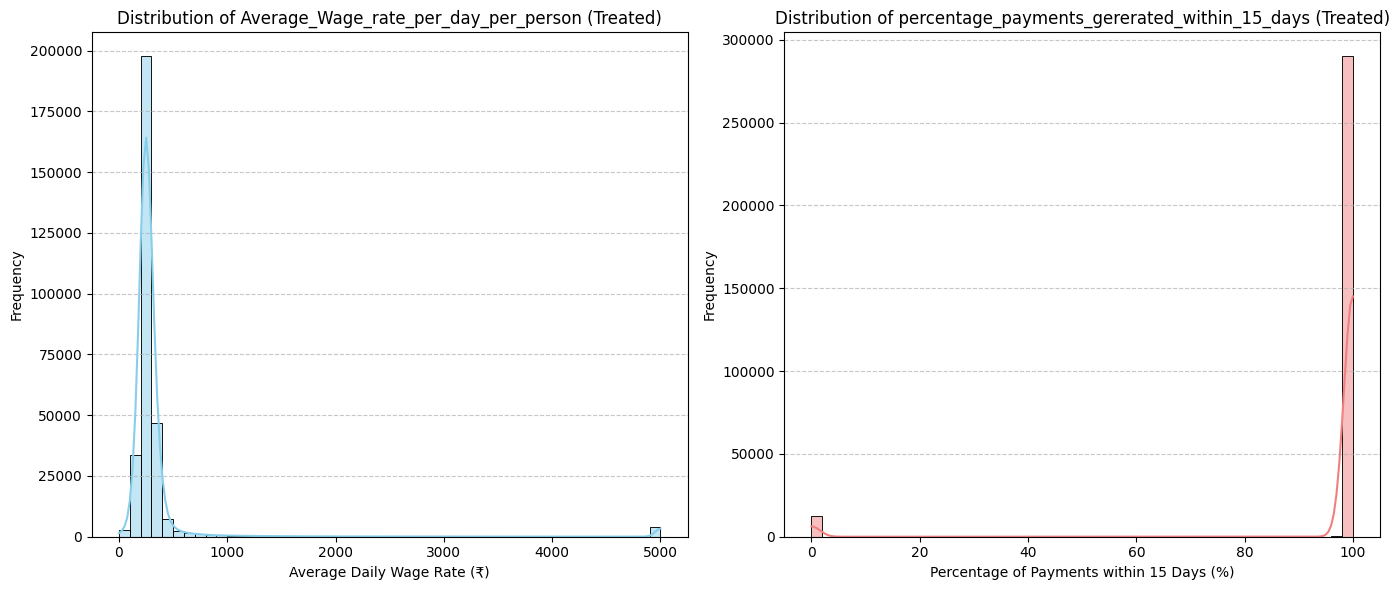

In [43]:

# --- Visualize distributions of treated columns to confirm improvements ---
plt.figure(figsize=(14, 6))

# Histogram for Average_Wage_rate_per_day_per_person
plt.subplot(1, 2, 1)
sns.histplot(df[wage_col], kde=True, bins=50, color='skyblue')
plt.title(f'Distribution of {wage_col} (Treated)')
plt.xlabel('Average Daily Wage Rate (₹)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Histogram for percentage_payments_gererated_within_15_days
plt.subplot(1, 2, 2)
sns.histplot(df[payments_col], kde=True, bins=50, color='lightcoral')
plt.title(f'Distribution of {payments_col} (Treated)')
plt.xlabel('Percentage of Payments within 15 Days (%)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


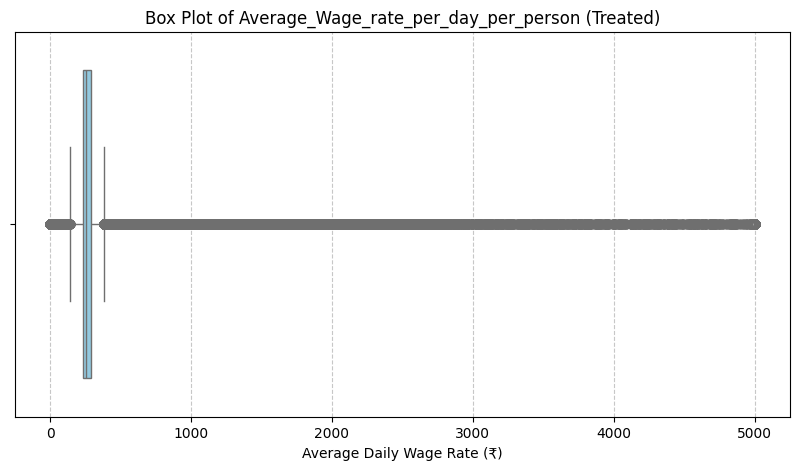

In [44]:

# Box Plot for Average_Wage_rate_per_day_per_person
plt.figure(figsize=(10, 5))
sns.boxplot(x=df[wage_col], color='skyblue')
plt.title(f'Box Plot of {wage_col} (Treated)')
plt.xlabel('Average Daily Wage Rate (₹)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


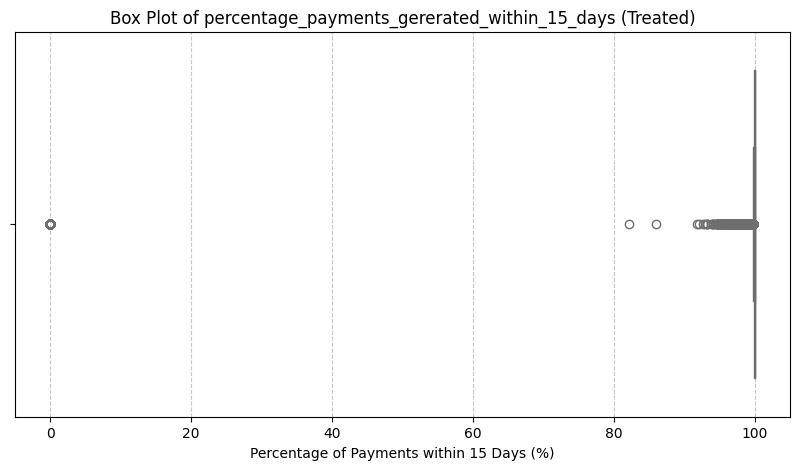


DataFrame saved after ETL Step 5 to: Datasets\Cleaned_Preprocessed\mgnrega_data_fully_cleaned.csv


In [45]:

# Box Plot for percentage_payments_gererated_within_15_days
plt.figure(figsize=(10, 5))
sns.boxplot(x=df[payments_col], color='lightcoral')
plt.title(f'Box Plot of {payments_col} (Treated)')
plt.xlabel('Percentage of Payments within 15 Days (%)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# Save the DataFrame after outlier treatment
try:
    df.to_csv(FULLY_CLEANED_CSV_FILE, index=False)
    print(f"\nDataFrame saved after ETL Step 5 to: {FULLY_CLEANED_CSV_FILE}")
except Exception as e:
    print(f"Error saving DataFrame after ETL Step 5: {e}")



In [46]:
# Load the fully cleaned dataset with robust data handling
try:
    df = pd.read_csv(FULLY_CLEANED_CSV_FILE)
    
    # --- Robust Numerical Column Re-conversion AFTER CSV Load ---
    # Ensure all numerical columns are correctly typed and handle inf/NaN.
    numerical_cols_to_reconvert = [
        'Approved_Labour_Budget', 'Average_Wage_rate_per_day_per_person',
        'Average_days_of_employment_provided_per_Household', 'Differently_abled_persons_worked',
        'Material_and_skilled_Wages', 'Number_of_Completed_Works',
        'Number_of_GPs_with_NIL_exp', 'Number_of_Ongoing_Works',
        'Persondays_of_Central_Liability_so_far', 'SC_persondays',
        'SC_workers_against_active_workers', 'ST_persondays',
        'ST_workers_against_active_workers', 'Total_Adm_Expenditure', 'Total_Exp',
        'Total_Households_Worked', 'Total_Individuals_Worked',
        'Total_No_of_Active_Job_Cards', 'Total_No_of_Active_Workers',
        'Total_No_of_HHs_completed_100_Days_of_Wage_Employment',
        'Total_No_of_JobCards_issued', 'Total_No_of_Workers',
        'Total_No_of_Works_Takenup', 'Wages', 'Women_Persondays',
        'percent_of_Category_B_Works', 'percent_of_Expenditure_on_Agriculture_Allied_Works',
        'percent_of_NRM_Expenditure', 'percentage_payments_gererated_within_15_days'
    ]

    for col in numerical_cols_to_reconvert:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].replace([np.inf, -np.inf], np.nan).fillna(0) # Handle inf/NaN with 0
    
    df['state_code'] = df['state_code'].fillna(-1).astype(int)
    df['district_code'] = df['district_code'].fillna(-1).astype(int)

    # --- NO GLOBAL DATE COLUMN CREATION (as discussed, will derive as needed) ---
    
    df['State'] = df['State'].astype('category')
    df['District'] = df['District'].astype('category')
    
    print(f"Loaded fully cleaned data from: {FULLY_CLEANED_CSV_FILE}")
    print(f"DataFrame shape after robust numerical handling: {df.shape}")

    # --- Filter out 2024-2025 and 2025-2026 for consistent historical analysis (NEW) ---
    print("\n--- Filtering Data for Consistent Historical Analysis (Excluding 2024-2025 and 2025-2026) ---")
    years_to_exclude = ['2024-2025', '2025-2026']
    df = df[~df['fin_year'].isin(years_to_exclude)].copy() # Filter the main DataFrame
    print(f"DataFrame shape after filtering {years_to_exclude}: {df.shape}")
    print(f"Financial years remaining in data: {df['fin_year'].unique()}")


    # --- Data Sorting ---
    print("\n--- Sorting DataFrame by Financial Year, Month (Financial Order), State Code, and District Code ---")
    # 1. Define month order for Indian Financial Year (April to March)
    financial_month_order = ['April', 'May', 'June', 'July', 'August', 'September', 
                             'October', 'November', 'December', 'January', 'February', 'March']
    
    # Create a more robust month_to_num mapping to handle both full and short month names
    # This dictionary is mainly for converting to numerical keys for comparison/sorting if needed,
    # but the primary sorting will leverage CategoricalDtype
    month_to_num_for_plotting = { # Use a different name to avoid confusion with sorting key
        'April': 0, 'May': 1, 'June': 2, 'July': 3, 'August': 4, 'September': 5, 
        'October': 6, 'November': 7, 'December': 8, 'January': 9, 'February': 10, 'March': 11,
        'Apr': 0, 'May': 1, 'Jun': 2, 'Jul': 3, 'Aug': 4, 'Sep': 5, 
        'Oct': 6, 'Nov': 7, 'Dec': 8, 'Jan': 9, 'Feb': 10, 'Mar': 11
    }
    
    # 2. Create numerical sorting key for fin_year
    df['fin_year_sort_key'] = df['fin_year'].astype(str).str.split('-').str[0].astype(int)

    # 3. Process 'month' column and convert to an ORDERED CategoricalDtype
    df['month_processed'] = df['month'].astype(str).str.strip().str.title()
    df['month_full_name_for_sort'] = df['month_processed'].apply(
        lambda x: next((m_full for m_full in financial_month_order if m_full.startswith(x)), x)
    )
    df['month_ordered'] = pd.Categorical(df['month_full_name_for_sort'], categories=financial_month_order, ordered=True)

    # 4. Sort the DataFrame using the custom ordered 'month_ordered'
    df.sort_values(by=['fin_year_sort_key', 'month_ordered', 'state_code', 'district_code'], inplace=True)

    # 5. Drop temporary sorting keys
    df.drop(columns=['fin_year_sort_key', 'month_processed', 'month_full_name_for_sort', 'month_ordered'], inplace=True, errors='ignore')
    print("DataFrame sorted successfully.")
    print(df[['fin_year', 'month', 'state_code', 'State', 'district_code', 'District']].head(20)) 


    # --- Save the fully cleaned, sorted, and FILTERED DataFrame (UPDATED PATH) ---
    df.to_csv(FINAL_FILTERED_SORTED_CSV_FILE, index=False)
    print(f"\nFiltered data for analysis saved to: {FINAL_FILTERED_SORTED_CSV_FILE}")


except FileNotFoundError:
    print(f"Error: The file '{FULLY_CLEANED_CSV_FILE}' was not found. Please ensure the path is correct.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred while loading the dataset: {e}")
    exit()


Loaded fully cleaned data from: Datasets\Cleaned_Preprocessed\mgnrega_data_fully_cleaned.csv
DataFrame shape after robust numerical handling: (302752, 36)

--- Filtering Data for Consistent Historical Analysis (Excluding 2024-2025 and 2025-2026) ---
DataFrame shape after filtering ['2024-2025', '2025-2026']: (50892, 36)
Financial years remaining in data: ['2019-2020' '2021-2022' '2020-2021' '2018-2019' '2022-2023' '2023-2024']

--- Sorting DataFrame by Financial Year, Month (Financial Order), State Code, and District Code ---
DataFrame sorted successfully.
         fin_year  month  state_code                State  district_code  \
2862    2018-2019  April           1  ANDAMAN AND NICOBAR            101   
2863    2018-2019  April           1  ANDAMAN AND NICOBAR            102   
127010  2018-2019  April           1  ANDAMAN AND NICOBAR            103   
127011  2018-2019  April           2       ANDHRA PRADESH            201   
254315  2018-2019  April           2       ANDHRA PRADESH

In [49]:

print("\n--- Starting EDA Step 3: Refined Visualizations and Deep Dive into Trends and Patterns ---")

# --- Feature Engineering for deeper insights (re-run to ensure consistency) ---
df['Women_Persondays_Ratio'] = df['Women_Persondays'] / df['Persondays_of_Central_Liability_so_far']
df['Women_Persondays_Ratio'] = df['Women_Persondays_Ratio'].replace([np.inf, -np.inf], np.nan).fillna(0) 
df['Women_Persondays_Ratio'] = np.clip(df['Women_Persondays_Ratio'], 0, 1) 

df['SC_Persondays_Ratio'] = df['SC_persondays'] / df['Persondays_of_Central_Liability_so_far']
df['SC_Persondays_Ratio'] = df['SC_Persondays_Ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['SC_Persondays_Ratio'] = np.clip(df['SC_Persondays_Ratio'], 0, 1)

df['ST_Persondays_Ratio'] = df['ST_persondays'] / df['Persondays_of_Central_Liability_so_far']
df['ST_Persondays_Ratio'] = df['ST_Persondays_Ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['ST_Persondays_Ratio'] = np.clip(df['ST_Persondays_Ratio'], 0, 1)

df['100_Days_HH_Ratio'] = df['Total_No_of_HHs_completed_100_Days_of_Wage_Employment'] / df['Total_Households_Worked']
df['100_Days_HH_Ratio'] = df['100_Days_HH_Ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['100_Days_HH_Ratio'] = np.clip(df['100_Days_HH_Ratio'], 0, 1)

print("\n--- Feature Engineering Completed ---")




--- Starting EDA Step 3: Refined Visualizations and Deep Dive into Trends and Patterns ---

--- Feature Engineering Completed ---


In [50]:

# --- Analysis by State (Visualizations with refined plots and explicit hue) ---
print("\n--- State-wise Aggregated Metrics ---")
# Aggregate all state performance metrics
state_performance = df.groupby('State').agg(
    Total_Expenditure=('Total_Exp', 'sum'),
    Total_Workers=('Total_No_of_Workers', 'sum'),
    Avg_Daily_Wage=('Average_Wage_rate_per_day_per_person', 'mean'),
    Avg_100_Days_HH_Ratio=('100_Days_HH_Ratio', 'mean'),
    Avg_Payment_Efficiency=('percentage_payments_gererated_within_15_days', 'mean'),
    Total_Women_Persondays=('Women_Persondays', 'sum'),
    Avg_Women_Persondays_Ratio=('Women_Persondays_Ratio', 'mean'),
    Avg_NRM_Exp_Percent=('percent_of_NRM_Expenditure', 'mean')
)

print("\n--- State Performance Aggregated Data (Head) ---")
print(state_performance.head())
print("\n--- State Performance Aggregated Data (Describe) ---")
print(state_performance.describe())



--- State-wise Aggregated Metrics ---

--- State Performance Aggregated Data (Head) ---
                     Total_Expenditure  Total_Workers  Avg_Daily_Wage  \
State                                                                   
ANDAMAN AND NICOBAR       2.324324e+04   4.157408e+06      460.459545   
ANDHRA PRADESH            4.084342e+07   1.289226e+09      207.741754   
ARUNACHAL PRADESH         1.436587e+06   3.570200e+07      441.097322   
ASSAM                     7.246806e+06   7.832448e+08      209.195901   
BIHAR                     2.381411e+07   1.836347e+09      182.112772   

                     Avg_100_Days_HH_Ratio  Avg_Payment_Efficiency  \
State                                                                
ANDAMAN AND NICOBAR               0.006548               71.759259   
ANDHRA PRADESH                    0.046128               99.982532   
ARUNACHAL PRADESH                 0.001937               74.132324   
ASSAM                             0.004152       

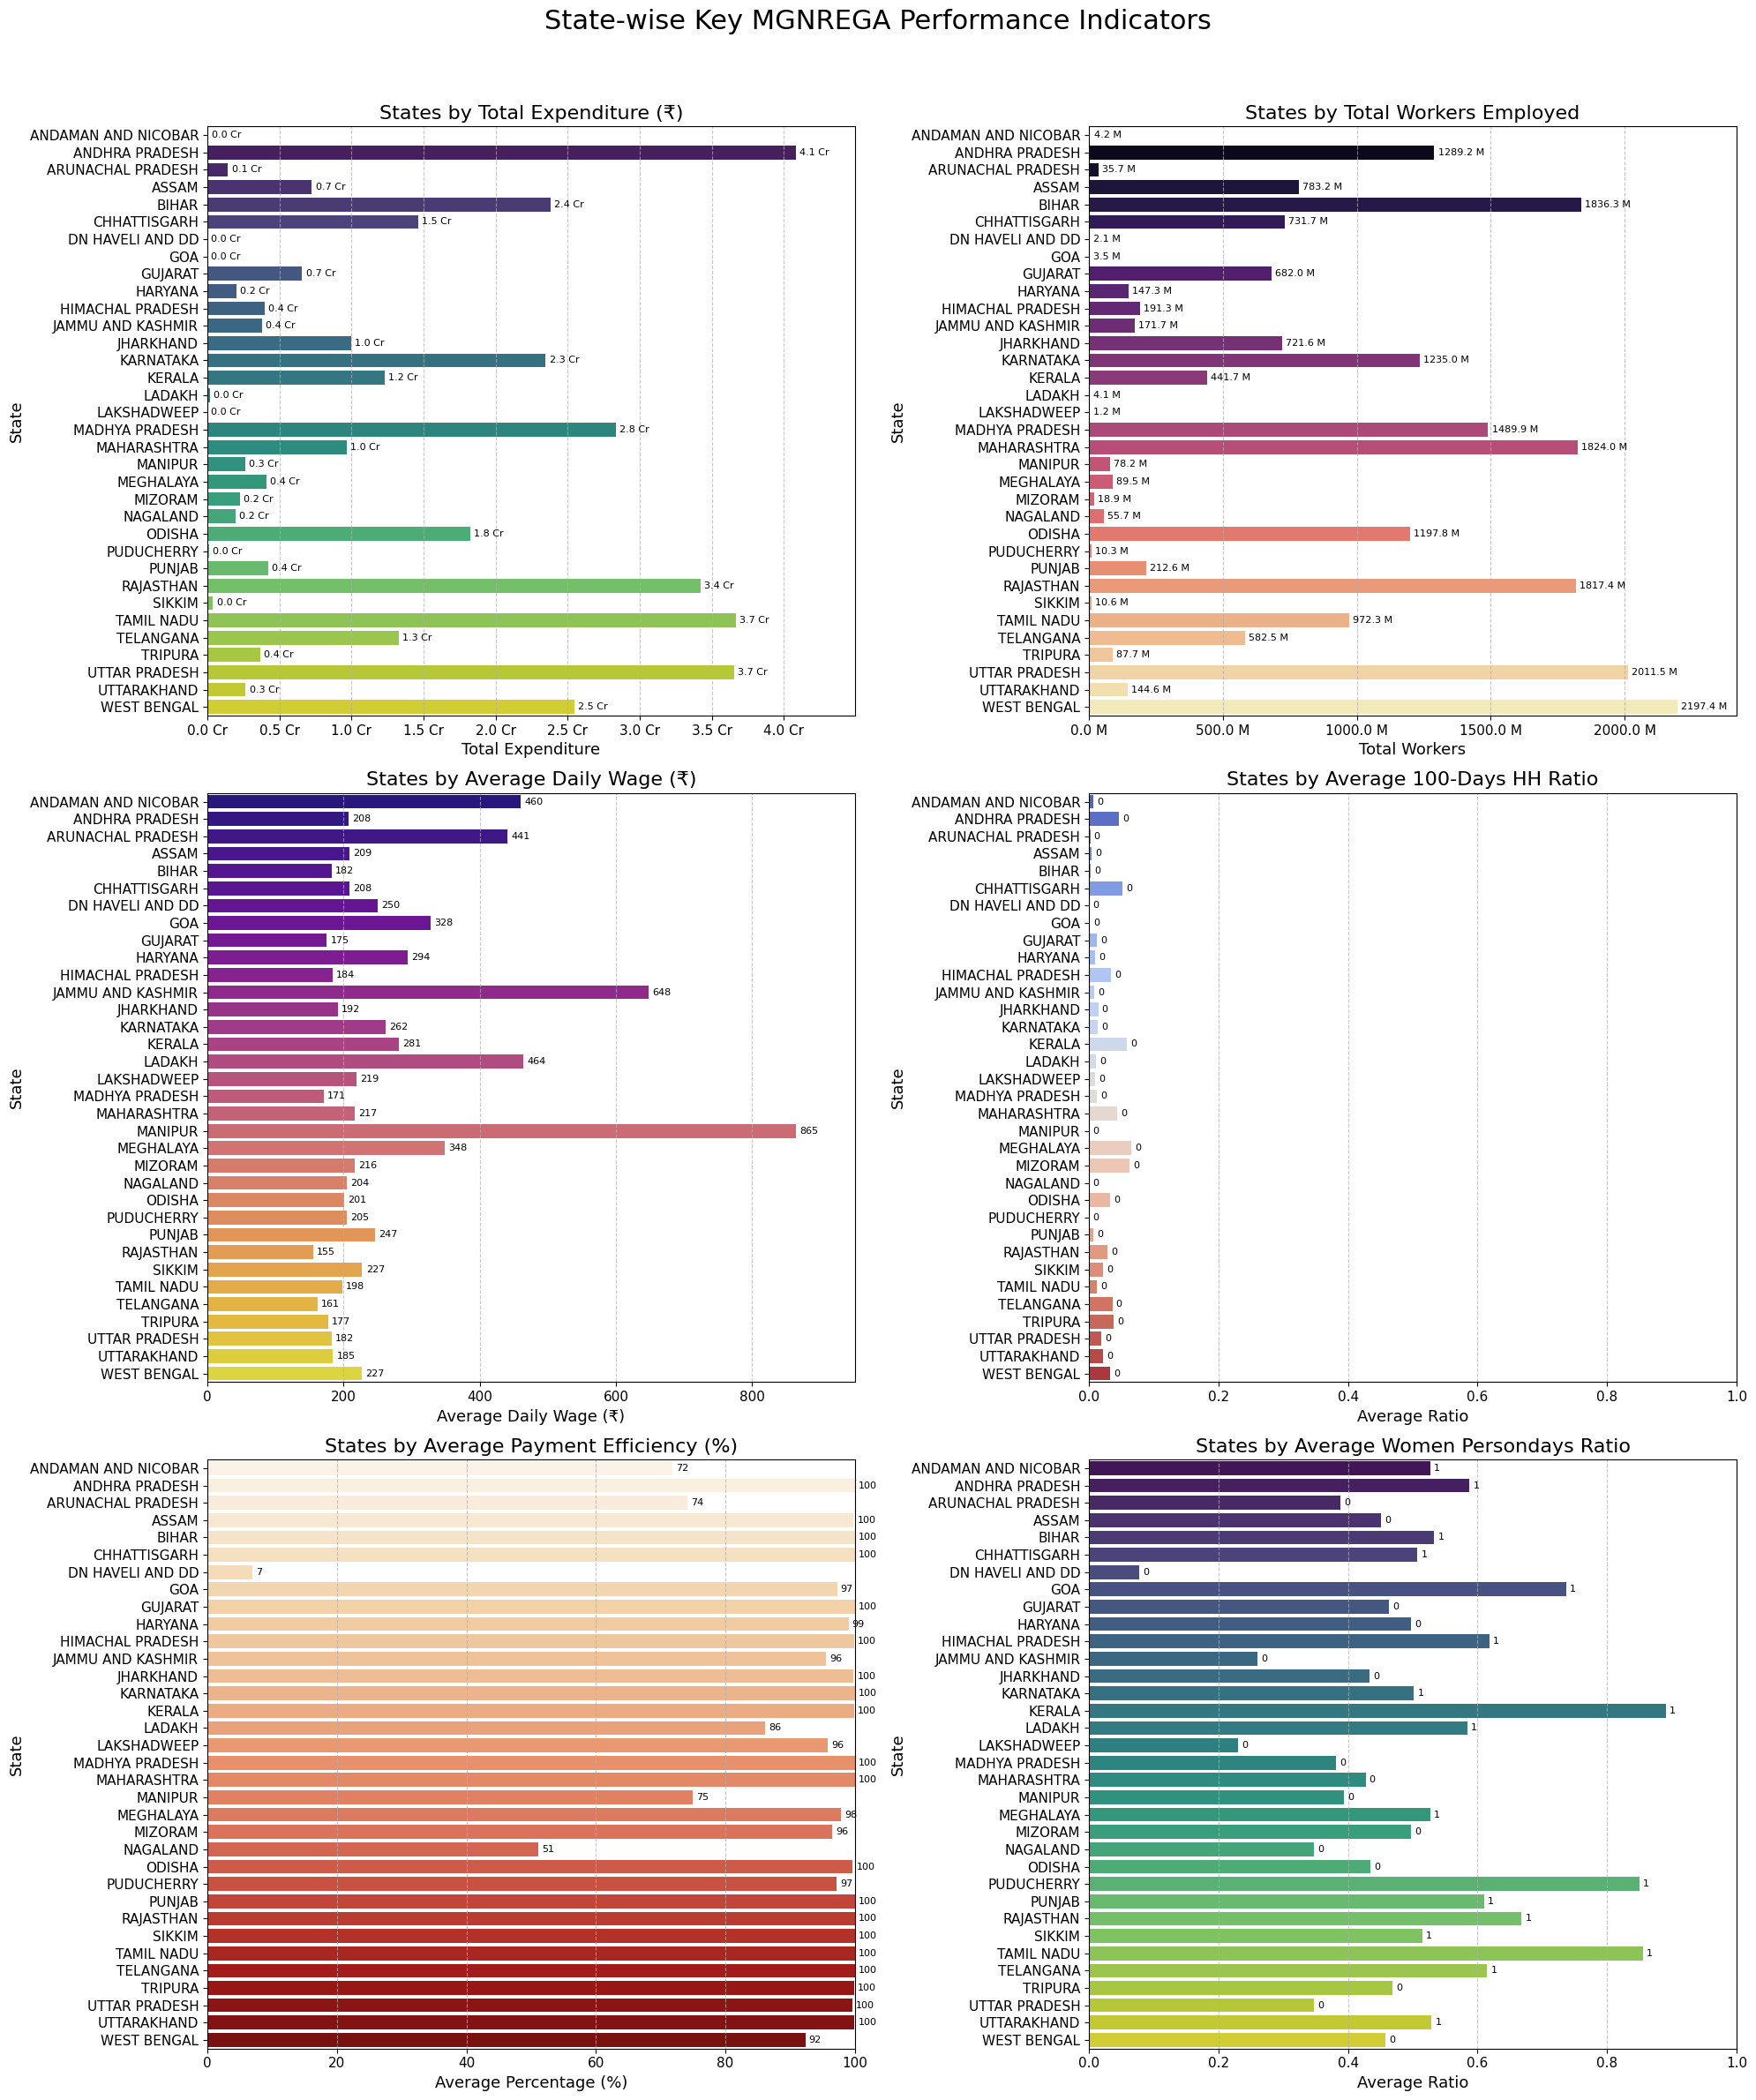

In [51]:

# Visualizations: Bar Charts for State Performance - Now showing all states, sorted by value, with value labels
fig, axes = plt.subplots(3, 2, figsize=(20, 25)) 
fig.suptitle('State-wise Key MGNREGA Performance Indicators', fontsize=22) # Changed title
plt.subplots_adjust(left=0.1, right=0.9, top=0.92, bottom=0.08, hspace=0.4, wspace=0.3) 

# Helper function to plot bar charts for state performance with values
def plot_state_bar_chart_with_values(ax, data, x_col, y_col, title, x_label, y_label, formatter=None, palette='viridis', ascending=False):
    # Sort data for plotting (highest values at the top)
    sorted_data = data.sort_values(by=x_col, ascending=ascending).reset_index()

    if not sorted_data.empty and not sorted_data[x_col].isnull().all() and not (sorted_data[x_col] == 0).all():
        bars = sns.barplot(x=x_col, y=y_col, data=sorted_data, ax=ax, palette=palette) 
        ax.set_title(title, fontsize=16)
        ax.set_xlabel(x_label, fontsize=13)
        ax.set_ylabel(y_label, fontsize=13)
        if formatter:
            ax.xaxis.set_major_formatter(plt.FuncFormatter(formatter))
        ax.tick_params(axis='x', labelsize=11)
        ax.tick_params(axis='y', labelsize=11)
        ax.grid(axis='x', linestyle='--', alpha=0.7)

        # Annotate bars with values
        for container in ax.containers: # Iterate through containers for bar_label
            ax.bar_label(container, fmt=formatter if formatter else '%.0f', 
                         labels=[formatter(v, None) if formatter else f'{v:.0f}' for v in container.datavalues],
                         fontsize=8, padding=3, color='black') # Default to black text, can refine
        
        # --- Dynamic xlim adjustment for better visibility ---
        if sorted_data[x_col].max() > 0:
            current_max_x = sorted_data[x_col].max()
            if 'Cr' in x_label: 
                ax.set_xlim(left=0, right=current_max_x * 1.1)
            elif 'M' in x_label:
                ax.set_xlim(left=0, right=current_max_x * 1.1)
            elif 'Ratio' in x_label:
                ax.set_xlim(left=0, right=1.0) 
            elif 'Percentage' in x_label:
                ax.set_xlim(left=0, right=100.0)
            elif 'Wage' in x_label:
                ax.set_xlim(left=0, right=max(current_max_x * 1.1, 850)) # Cap wage at 850 if values are low, otherwise scale to max
            else: 
                ax.set_xlim(left=0, right=current_max_x * 1.1)
                
    else:
        ax.set_title(f"No meaningful data for {title.split('by ')[1]}", fontsize=16)
        ax.text(0.5, 0.5, 'Data not available or all zeros', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=14, color='red')
        ax.set_visible(True) # Ensure axis is visible to show "No Data" message
        ax.set_xticks([])
        ax.set_yticks([])

# Plot 1: States by Total Expenditure (₹)
plot_state_bar_chart_with_values(axes[0, 0], state_performance, # Changed to show all states
                     'Total_Expenditure', 'State',
                     'States by Total Expenditure (₹)', 'Total Expenditure', 'State',
                     lambda x, _: f'{x/1e7:.1f} Cr', 'viridis', ascending=True) 
# Comment for Plot 1
"""
Purpose: To visualize the total financial investment in MGNREGA across all states.
Insights: Identifies states with the largest and smallest overall expenditure.
Interpretation: Highlights states with substantial program scale. Large disparities suggest varying levels of program implementation or regional demands for work. The bar labels provide exact figures, aiding precise comparison.
"""


# Plot 2: States by Total Workers Employed
plot_state_bar_chart_with_values(axes[0, 1], state_performance, # Changed to show all states
                     'Total_Workers', 'State', 'States by Total Workers Employed',
                     'Total Workers', 'State', lambda x, _: f'{x/1e6:.1f} M', 'magma', ascending=True)
# Comment for Plot 2
"""
Purpose: To visualize the total number of workers engaged in MGNREGA activities across all states.
Insights: Shows the geographical reach of the scheme in terms of human resource engagement.
Interpretation: High worker numbers are critical for livelihood support. These figures are cumulative over time, not unique individuals, indicating the volume of employment generated. Labels offer precise worker counts.
"""


# Plot 3: States by Average Daily Wage (₹)
plot_state_bar_chart_with_values(axes[1, 0], state_performance, # Changed to show all states
                     'Avg_Daily_Wage', 'State', 'States by Average Daily Wage (₹)',
                     'Average Daily Wage (₹)', 'State', palette='plasma', ascending=True)
# Comment for Plot 3
"""
Purpose: To compare the average daily wage rates offered by MGNREGA across different states.
Insights: Reveals regional variations in compensation for work under the scheme.
Interpretation: Differences in average wages can stem from variations in state-specific minimum wages or the nature of work (skilled vs. unskilled). Higher wages improve worker earnings, while lower wages might indicate areas needing policy review to ensure fair compensation.
"""

# Plot 4: States by Average 100-Days HH Ratio
plot_state_bar_chart_with_values(axes[1, 1], state_performance, # Changed to show all states
                     'Avg_100_Days_HH_Ratio', 'State', 'States by Average 100-Days HH Ratio',
                     'Average Ratio', 'State', palette='coolwarm', ascending=True)
# Comment for Plot 4
"""
Purpose: To assess the proportion of households completing the guaranteed 100 days of employment across states.
Insights: A key indicator of the scheme's effectiveness in providing sustained livelihood support.
Interpretation: Very low ratios across all states suggest a significant gap between the scheme's intent and its execution on the ground. States with higher ratios are more successful in this core objective. This gap could be due to demand-side issues (workers not seeking 100 days) or supply-side issues (lack of available work, administrative hurdles).
"""

# Plot 5: States by Average Payment Efficiency (%)
plot_state_bar_chart_with_values(axes[2, 0], state_performance, # Changed to show all states
                     'Avg_Payment_Efficiency', 'State', 'States by Average Payment Efficiency (%)',
                     'Average Percentage (%)', 'State', palette='OrRd', ascending=True) 
# Comment for Plot 5
"""
Purpose: To visualize states' administrative efficiency in disbursing wages within the stipulated 15 days.
Insights: Highlights states with high and low adherence to timely payment.
Interpretation: High payment efficiency is crucial for worker welfare, reducing financial stress and increasing trust in the scheme. Low efficiency in some states indicates administrative bottlenecks that require urgent attention.
"""

# Plot 6: States by Average Women Persondays Ratio
plot_state_bar_chart_with_values(axes[2, 1], state_performance, # Changed to show all states
                     'Avg_Women_Persondays_Ratio', 'State', 'States by Average Women Persondays Ratio',
                     'Average Ratio', 'State', palette='viridis', ascending=True)
# Comment for Plot 6
"""
Purpose: To assess gender inclusivity and the proportion of employment generated for women across states.
Insights: Reveals states that are more successful in mobilizing and providing work for women.
Interpretation: Higher ratios signify better gender equity in MGNREGA implementation. This is a vital social equity metric, indicating successful efforts in empowering women in the rural workforce. Lower ratios might suggest cultural barriers or lack of suitable work for women in those regions.
"""

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()




--- Trends Over Financial Years ---
Yearly Trends (Operating on filtered data):
           Total_Expenditure  Total_Workers  Avg_Daily_Wage  \
fin_year                                                      
2018-2019       4.332698e+07   3.307431e+09      215.354496   
2019-2020       4.202751e+07   3.374215e+09      225.300330   
2020-2021       7.354912e+07   3.713326e+09      231.115160   
2021-2022       7.468682e+07   3.837848e+09      232.384528   
2022-2023       6.748102e+07   3.671221e+09      274.078549   
2023-2024       7.362989e+07   3.178792e+09      269.381790   

           Avg_100_Days_HH_Ratio  Avg_Payment_Efficiency  
fin_year                                                  
2018-2019               0.021104               95.018298  
2019-2020               0.018640               95.453846  
2020-2021               0.027561               97.118983  
2021-2022               0.024389               97.668608  
2022-2023               0.016337               98.318128  
2

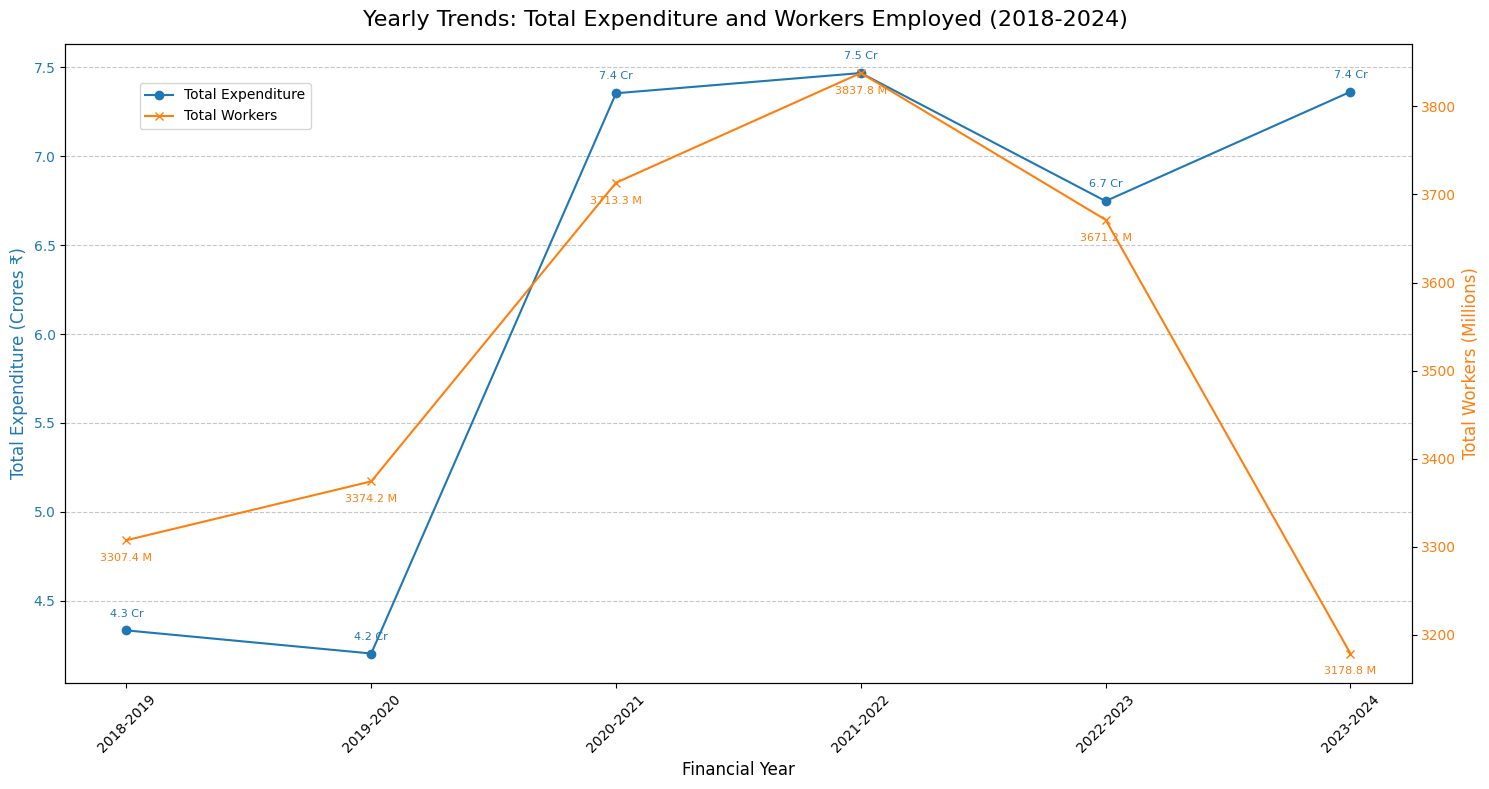

'\nPurpose: To visualize the overall temporal evolution of financial investment and human resource utilization under MGNREGA for historically consistent years.\nInsights: Reveals major spikes or dips in activity for comparable periods. Excludes 2024-2025 and 2025-2026 for accurate trend representation due to data granularity and completeness issues.\nInterpretation: A generally increasing trend over years indicates program expansion or increased demand. Consistent trend analysis is now possible. Scaling to crores and millions helps in readability for large numbers. Annotated values provide precise figures for each year.\n'

In [52]:

# --- Analysis by Time (Financial Year and Month) ---
print("\n--- Trends Over Financial Years ---")

# --- Deriving calendar_year and calendar_month on-the-fly for time series ---
# This ensures we are not relying on a globally created 'Date' column and its potential issues
# Updated month_order to reflect Indian financial year starting April
financial_month_order_for_plot = ['April', 'May', 'June', 'July', 'August', 'September', 
                                  'October', 'November', 'December', 'January', 'February', 'March']

short_to_full_month_map = {
    'Jan': 'January', 'Feb': 'February', 'Mar': 'March', 'Apr': 'April',
    'May': 'May', 'Jun': 'June', 'Jul': 'July', 'Aug': 'August',
    'Sep': 'September', 'Oct': 'October', 'Nov': 'November', 'Dec': 'December'
}
month_to_num_for_fy = {month: i for i, month in enumerate(financial_month_order_for_plot)}


# Create a temporary DataFrame for time series analysis
df_temp_time = df.copy() # df is already filtered now

# Ensure 'month' column is clean before mapping
df_temp_time['month_cleaned_for_temp'] = df_temp_time['month'].astype(str).str.strip().str.title()

# Map short names to full names, and then get numerical order
df_temp_time['month_full_name'] = df_temp_time['month_cleaned_for_temp'].map(short_to_full_month_map).fillna(df_temp_time['month_cleaned_for_temp'])
df_temp_time['month_num_fy_order'] = df_temp_time['month_full_name'].map(month_to_num_for_fy)


df_temp_time['start_year_temp'] = df_temp_time['fin_year'].astype(str).str.split('-').str[0].astype(int)

# Corrected get_calendar_year_for_temp logic for Indian financial year (April-March)
def get_calendar_year_for_temp(row):
    start_year = row['start_year_temp']
    month_num_fy_order = row['month_num_fy_order'] # Using the order number for current year determination
    
    if pd.isna(start_year) or pd.isna(month_num_fy_order):
        return np.nan
    
    # If month is April-Dec (0-8 in financial_month_order_for_plot index), it's the start year
    # If month is Jan-Mar (9-11 in financial_month_order_for_plot index), it's start_year + 1
    if month_num_fy_order >= month_to_num_for_fy['April']: # Months from April to December (index 0 to 8)
        return int(start_year)
    else: # Months January to March (index 9 to 11)
        return int(start_year + 1)

df_temp_time['calendar_year_temp'] = df_temp_time.apply(get_calendar_year_for_temp, axis=1)

# Drop rows with NaNs in necessary temporal columns
df_temp_time.dropna(subset=['month_num_fy_order', 'calendar_year_temp'], inplace=True)
df_temp_time['calendar_year_temp'] = df_temp_time['calendar_year_temp'].astype(int)

# Filter for yearly trends (no further filtering needed, df is already filtered)
yearly_trends = df_temp_time.groupby('fin_year').agg(
    Total_Expenditure=('Total_Exp', 'sum'),
    Total_Workers=('Total_No_of_Workers', 'sum'),
    Avg_Daily_Wage=('Average_Wage_rate_per_day_per_person', 'mean'),
    Avg_100_Days_HH_Ratio=('100_Days_HH_Ratio', 'mean'),
    Avg_Payment_Efficiency=('percentage_payments_gererated_within_15_days', 'mean')
).sort_values(by='fin_year')

print("Yearly Trends (Operating on filtered data):")
print(yearly_trends)


# Refined Yearly Trends Plot: Using two separate line plots for clarity
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot Total Expenditure
color = 'tab:blue'
ax1.set_xlabel('Financial Year', fontsize=12)
ax1.set_ylabel('Total Expenditure (Crores ₹)', color=color, fontsize=12)
line1 = ax1.plot(yearly_trends.index, yearly_trends['Total_Expenditure'] / 1e7, color=color, marker='o', label='Total Expenditure')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45) 
ax1.grid(axis='y', linestyle='--', alpha=0.7) 

# Annotate points for Total Expenditure
for x, y in zip(yearly_trends.index, yearly_trends['Total_Expenditure'] / 1e7):
    ax1.annotate(f'{y:.1f} Cr', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color=color)


# Plot Total Workers on a twin axis
ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('Total Workers (Millions)', color=color, fontsize=12)
line2 = ax2.plot(yearly_trends.index, yearly_trends['Total_Workers'] / 1e6, color=color, marker='x', label='Total Workers')
ax2.tick_params(axis='y', labelcolor=color)

# Annotate points for Total Workers
for x, y in zip(yearly_trends.index, yearly_trends['Total_Workers'] / 1e6):
    ax2.annotate(f'{y:.1f} M', (x, y), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color=color)


fig.suptitle('Yearly Trends: Total Expenditure and Workers Employed (2018-2024)', fontsize=16) # Updated title
# Add a combined legend from both axes
lines_combined = line1 + line2
labels_combined = [l.get_label() for l in lines_combined]
ax2.legend(lines_combined, labels_combined, loc='upper left', bbox_to_anchor=(0.05, 0.95))
fig.tight_layout()
plt.show()
# Comment for Yearly Trends: Total Expenditure and Workers Employed
"""
Purpose: To visualize the overall temporal evolution of financial investment and human resource utilization under MGNREGA for historically consistent years.
Insights: Reveals major spikes or dips in activity for comparable periods. Excludes 2024-2025 and 2025-2026 for accurate trend representation due to data granularity and completeness issues.
Interpretation: A generally increasing trend over years indicates program expansion or increased demand. Consistent trend analysis is now possible. Scaling to crores and millions helps in readability for large numbers. Annotated values provide precise figures for each year.
"""


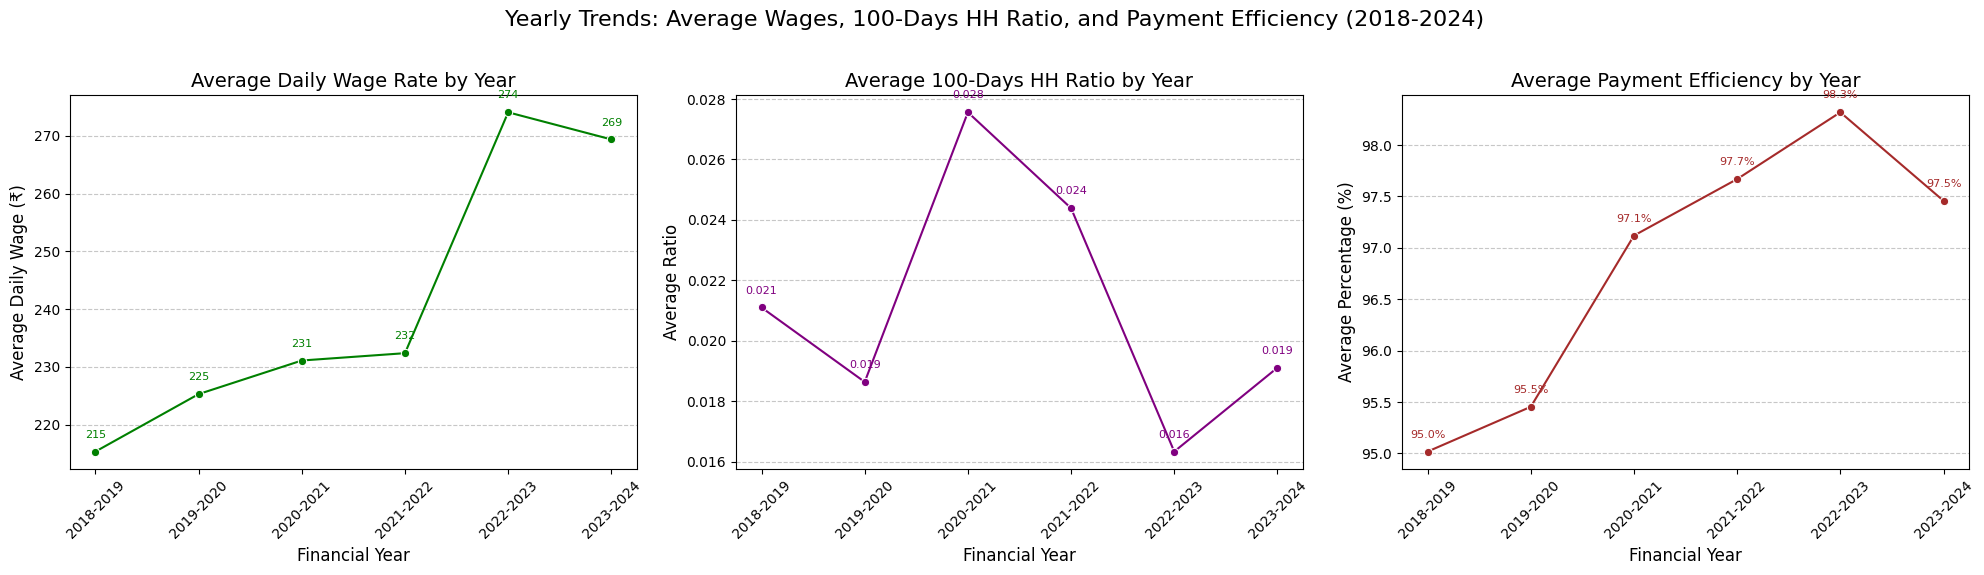

In [53]:

# Separate plots for other yearly trends for clarity
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Yearly Trends: Average Wages, 100-Days HH Ratio, and Payment Efficiency (2018-2024)', fontsize=16) # Updated title

# Plot Avg_Daily_Wage by Year
sns.lineplot(x=yearly_trends.index, y='Avg_Daily_Wage', data=yearly_trends, marker='o', ax=axes[0], color='green')
axes[0].set_title('Average Daily Wage Rate by Year', fontsize=14)
axes[0].set_xlabel('Financial Year', fontsize=12)
axes[0].set_ylabel('Average Daily Wage (₹)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
# Annotate points
for x, y in zip(yearly_trends.index, yearly_trends['Avg_Daily_Wage']):
    axes[0].annotate(f'{y:.0f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='green')
# Comment for Plot (Avg_Daily_Wage)
"""
Purpose: To track the trend of average daily wages provided under MGNREGA over time for consistent years.
Insights: Shows whether worker income is increasing or stagnating.
Interpretation: A consistent upward trend is a positive sign for improving livelihood standards under the scheme. Any stagnation or decrease would warrant concern and policy review. Excludes anomalous years. Annotated values provide precise figures.
"""

# Plot Avg_100_Days_HH_Ratio by Year
sns.lineplot(x=yearly_trends.index, y='Avg_100_Days_HH_Ratio', data=yearly_trends, marker='o', ax=axes[1], color='purple')
axes[1].set_title('Average 100-Days HH Ratio by Year', fontsize=14)
axes[1].set_xlabel('Financial Year', fontsize=12)
axes[1].set_ylabel('Average Ratio', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
# Annotate points
for x, y in zip(yearly_trends.index, yearly_trends['Avg_100_Days_HH_Ratio']):
    axes[1].annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='purple')
# Comment for Plot (Avg_100_Days_HH_Ratio)
"""
Purpose: To understand the longitudinal effectiveness of providing the full 100 days of guaranteed work for consistent years.
Insights: Reveals the scheme's success in delivering its core promise. Low or declining trends highlight challenges.
Interpretation: Observed trends in this ratio are critical for policy attention. Possible reasons for fluctuations include demand for work, administrative bottlenecks, or policy shifts. Annotated values provide precise figures.
"""

# Plot Avg_Payment_Efficiency by Year
sns.lineplot(x=yearly_trends.index, y='Avg_Payment_Efficiency', data=yearly_trends, marker='o', ax=axes[2], color='brown')
axes[2].set_title('Average Payment Efficiency by Year', fontsize=14)
axes[2].set_xlabel('Financial Year', fontsize=12)
axes[2].set_ylabel('Average Percentage (%)', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
# Annotate points
for x, y in zip(yearly_trends.index, yearly_trends['Avg_Payment_Efficiency']):
    axes[2].annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='brown')
# Comment for Plot (Avg_Payment_Efficiency)
"""
Purpose: To monitor the efficiency of wage disbursement over financial years for consistent years.
Insights: Timely payments are crucial for worker welfare. A high and stable percentage is ideal.
Interpretation: Observed efficiency trends are critical for understanding administrative performance. Any dips warrant investigation, as payment delays can severely impact the financial stability of workers. Annotated values provide precise figures.
"""

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()



In [54]:

# Monthly trends (considering all years for seasonality)
# df is already filtered, so df_temp_time will also be filtered
df_filtered_for_monthly = df_temp_time.copy() 
df_filtered_for_monthly.dropna(subset=['month_num_fy_order', 'calendar_year_temp'], inplace=True) 

# Debugging the content of df_filtered_for_monthly just before monthly aggregation
print("\n--- Debugging df_filtered_for_monthly before Monthly Aggregation ---")
print(f"Shape: {df_filtered_for_monthly.shape}")
print(f"month_num_fy_order nulls: {df_filtered_for_monthly['month_num_fy_order'].isnull().sum()}")
print(f"calendar_year_temp nulls: {df_filtered_for_monthly['calendar_year_temp'].isnull().sum()}")
print(f"Financial years present: {df_filtered_for_monthly['fin_year'].unique()}")
print(f"Sample of data for monthly trends:\n{df_filtered_for_monthly[['fin_year', 'month', 'Total_Exp', 'Total_No_of_Workers', 'Average_Wage_rate_per_day_per_person']].head()}")
print(f"Sum of Total_Exp in df_filtered_for_monthly: {df_filtered_for_monthly['Total_Exp'].sum()}")
print(f"Sum of Total_No_of_Workers in df_filtered_for_monthly: {df_filtered_for_monthly['Total_No_of_Workers'].sum()}")


df_filtered_for_monthly['calendar_month'] = df_filtered_for_monthly['month'].astype(str).str.strip().str.title().astype('category')

# Updated month_order to reflect Indian financial year starting April
month_order_financial_year = ['April', 'May', 'June', 'July', 'August', 'September', 
                               'October', 'November', 'December', 'January', 'February', 'March']

# Re-map short month names to full for consistent ordering and mapping
short_to_full_month = {
    'Jan': 'January', 'Feb': 'February', 'Mar': 'March', 'Apr': 'April',
    'May': 'May', 'Jun': 'June', 'Jul': 'July', 'Aug': 'August',
    'Sep': 'September', 'Oct': 'October', 'Nov': 'November', 'Dec': 'December'
}
df_filtered_for_monthly['calendar_month'] = df_filtered_for_monthly['calendar_month'].map(short_to_full_month).fillna(df_filtered_for_monthly['calendar_month']) # Map short to full, keep full as is
df_filtered_for_monthly['calendar_month'] = pd.Categorical(df_filtered_for_monthly['calendar_month'], categories=month_order_financial_year, ordered=True) # Use new financial year month order


monthly_trends = df_filtered_for_monthly.groupby('calendar_month').agg(
    Total_Expenditure=('Total_Exp', 'sum'),
    Total_Workers=('Total_No_of_Workers', 'sum'),
    Avg_Daily_Wage=('Average_Wage_rate_per_day_per_person', 'mean'),
    Avg_100_Days_HH_Ratio=('100_Days_HH_Ratio', 'mean'), 
    Avg_Payment_Efficiency=('percentage_payments_gererated_within_15_days', 'mean')
).reindex(month_order_financial_year) # Order months for consistent plotting

monthly_trends = monthly_trends.fillna(0) 




--- Debugging df_filtered_for_monthly before Monthly Aggregation ---
Shape: (50892, 45)
month_num_fy_order nulls: 0
calendar_year_temp nulls: 0
Financial years present: ['2018-2019' '2019-2020' '2020-2021' '2021-2022' '2022-2023' '2023-2024']
Sample of data for monthly trends:
         fin_year  month    Total_Exp  Total_No_of_Workers  \
2862    2018-2019  April     4.369320              18558.0   
2863    2018-2019  April     0.000000               9786.0   
127010  2018-2019  April     0.150230              32903.0   
127011  2018-2019  April  6662.301165            1320134.0   
254315  2018-2019  April  6176.642097            1222586.0   

        Average_Wage_rate_per_day_per_person  
2862                               37.013536  
2863                              252.492009  
127010                            252.492009  
127011                            140.062250  
254315                            123.668847  
Sum of Total_Exp in df_filtered_for_monthly: 374701344.0047136
Sum


--- Monthly Trends (Aggregated Across All Years, for 2018-2024 FYs) ---
                Total_Expenditure  Total_Workers  Avg_Daily_Wage  \
calendar_month                                                     
April                3.501258e+06   1.759502e+09      306.991754   
May                  9.071760e+06   1.763155e+09      252.167022   
June                 1.613888e+07   1.765832e+09      269.522965   
July                 2.221178e+07   1.767538e+09      258.861407   
August               2.722379e+07   1.767046e+09      250.516487   
September            3.121897e+07   1.767238e+09      239.753141   
October              3.486475e+07   1.766182e+09      232.320477   
November             3.831889e+07   1.764144e+09      225.823328   
December             4.218389e+07   1.755753e+09      221.710547   
January              4.567729e+07   1.744826e+09      217.258905   
February             4.909899e+07   1.736200e+09      210.659327   
March                5.519109e+07   1.72541

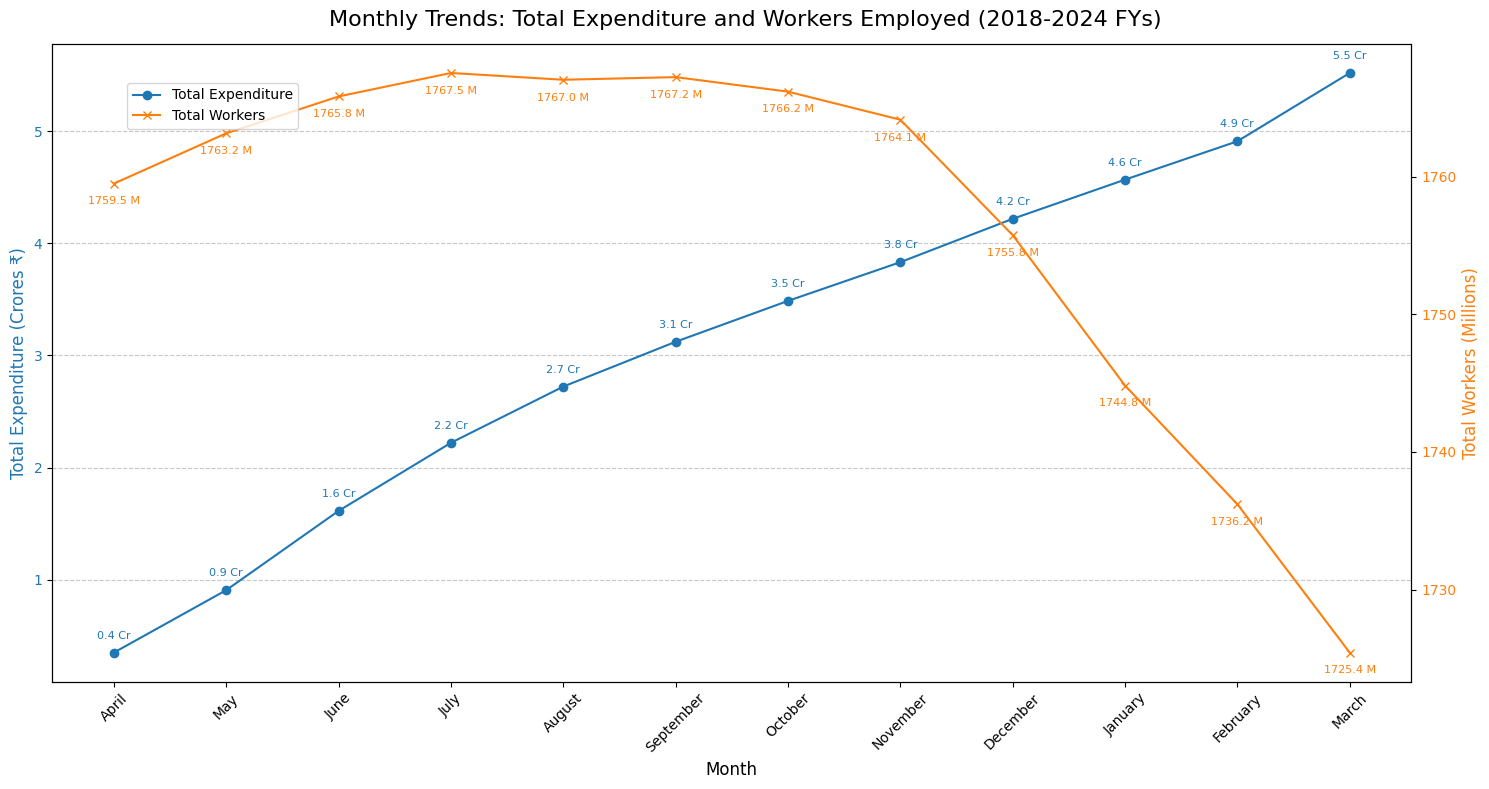

'\nPurpose: To identify seasonal patterns in MGNREGA expenditure and worker engagement, aligned with the Indian financial year, using historically consistent data (2018-2024 FYs).\nInsights: Reveals peak and lean periods of activity within the financial year.\nInterpretation: Activity often aligns with agricultural cycles (e.g., lower demand during peak agricultural seasons, higher during lean periods). Understanding these cycles is crucial for efficient resource planning and matching work availability with demand. This plot aggregates data across all complete financial years. Annotated values provide precise figures.\n'

In [55]:

print("\n--- Monthly Trends (Aggregated Across All Years, for 2018-2024 FYs) ---") # Updated title
print(monthly_trends)
print("\n--- Monthly Trends Describe ---")
print(monthly_trends.describe()) 

fig, ax1 = plt.subplots(figsize=(15, 8))

color = 'tab:blue'
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Total Expenditure (Crores ₹)', color=color, fontsize=12)
line1_monthly = ax1.plot(monthly_trends.index, monthly_trends['Total_Expenditure'] / 1e7, color=color, marker='o', label='Total Expenditure')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7) 

# Annotate points for Total Expenditure (Monthly)
for x, y in zip(monthly_trends.index, monthly_trends['Total_Expenditure'] / 1e7):
    ax1.annotate(f'{y:.1f} Cr', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color=color)


ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Total Workers (Millions)', color=color, fontsize=12)
line2_monthly = ax2.plot(monthly_trends.index, monthly_trends['Total_Workers'] / 1e6, color=color, marker='x', label='Total Workers')
ax2.tick_params(axis='y', labelcolor=color)

# Annotate points for Total Workers (Monthly)
for x, y in zip(monthly_trends.index, monthly_trends['Total_Workers'] / 1e6):
    ax2.annotate(f'{y:.1f} M', (x, y), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color=color)


fig.suptitle('Monthly Trends: Total Expenditure and Workers Employed (2018-2024 FYs)', fontsize=16) # Updated title
lines_combined_monthly = line1_monthly + line2_monthly
labels_combined_monthly = [l.get_label() for l in lines_combined_monthly]
ax2.legend(lines_combined_monthly, labels_combined_monthly, loc='upper left', bbox_to_anchor=(0.05, 0.95))
fig.tight_layout()
plt.show()
# Comment for Monthly Trends: Total Expenditure and Workers Employed
"""
Purpose: To identify seasonal patterns in MGNREGA expenditure and worker engagement, aligned with the Indian financial year, using historically consistent data (2018-2024 FYs).
Insights: Reveals peak and lean periods of activity within the financial year.
Interpretation: Activity often aligns with agricultural cycles (e.g., lower demand during peak agricultural seasons, higher during lean periods). Understanding these cycles is crucial for efficient resource planning and matching work availability with demand. This plot aggregates data across all complete financial years. Annotated values provide precise figures.
"""


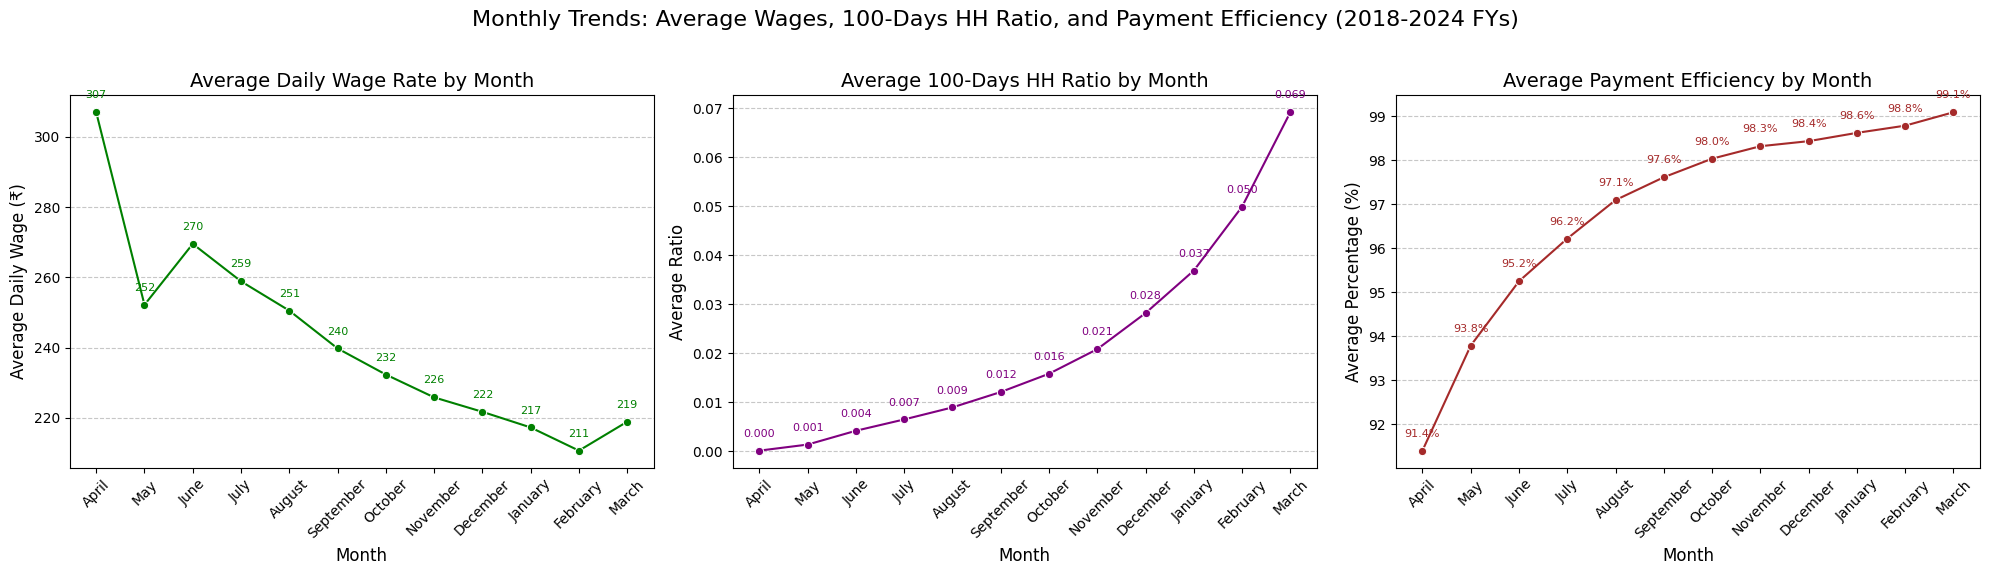

In [56]:

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Monthly Trends: Average Wages, 100-Days HH Ratio, and Payment Efficiency (2018-2024 FYs)', fontsize=16) # Updated title

# Plot Avg_Daily_Wage by Month
sns.lineplot(x=monthly_trends.index, y='Avg_Daily_Wage', data=monthly_trends, marker='o', ax=axes[0], color='green')
axes[0].set_title('Average Daily Wage Rate by Month', fontsize=14)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Average Daily Wage (₹)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
# Annotate points
for x, y in zip(monthly_trends.index, monthly_trends['Avg_Daily_Wage']):
    axes[0].annotate(f'{y:.0f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='green')
# Comment for Plot (Avg_Daily_Wage by Month)
"""
Purpose: To analyze monthly variations in average daily wage rates, aligned with the Indian financial year, for consistent historical data.
Insights: Can show if wages fluctuate seasonally or are relatively stable throughout the year.
Interpretation: Significant monthly fluctuations might indicate changes in work types or local economic conditions. Relative stability, especially near the median, suggests consistent wage policy application. Annotated values provide precise figures.
"""

# Plot Avg_100_Days_HH_Ratio by Month
sns.lineplot(x=monthly_trends.index, y='Avg_100_Days_HH_Ratio', data=monthly_trends, marker='o', ax=axes[1], color='purple')
axes[1].set_title('Average 100-Days HH Ratio by Month', fontsize=14)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Average Ratio', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
# Annotate points
for x, y in zip(monthly_trends.index, monthly_trends['Avg_100_Days_HH_Ratio']):
    axes[1].annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='purple')
# Comment for Plot (Avg_100_Days_HH_Ratio by Month)
"""
Purpose: To identify monthly patterns in the provision of 100 days of employment, aligned with the Indian financial year, for consistent historical data.
Insights: Reveals if certain months are better or worse for achieving this key scheme objective.
Interpretation: Seasonal peaks might align with lean agricultural seasons when demand for work is highest. Understanding these patterns can help target interventions. Annotated values provide precise figures.
"""

# Plot Avg_Payment_Efficiency by Month
sns.lineplot(x=monthly_trends.index, y='Avg_Payment_Efficiency', data=monthly_trends, marker='o', ax=axes[2], color='brown')
axes[2].set_title('Average Payment Efficiency by Month', fontsize=14)
axes[2].set_xlabel('Month', fontsize=12)
axes[2].set_ylabel('Average Percentage (%)', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
# Annotate points
for x, y in zip(monthly_trends.index, monthly_trends['Avg_Payment_Efficiency']):
    axes[2].annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='brown')
# Comment for Plot (Avg_Payment_Efficiency by Month)
"""
Purpose: To assess monthly consistency in payment efficiency, aligned with the Indian financial year, for consistent historical data.
Insights: Can highlight months where administrative bottlenecks or external factors might cause payment delays.
Interpretation: Stable high efficiency indicates a robust system. Dips can signal areas where the payment mechanism needs strengthening, especially if it coincides with peak work demand. Annotated values provide precise figures.
"""
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()




--- Monthly Trends by Financial Year for Key Metrics (2018-2024 FYs) ---


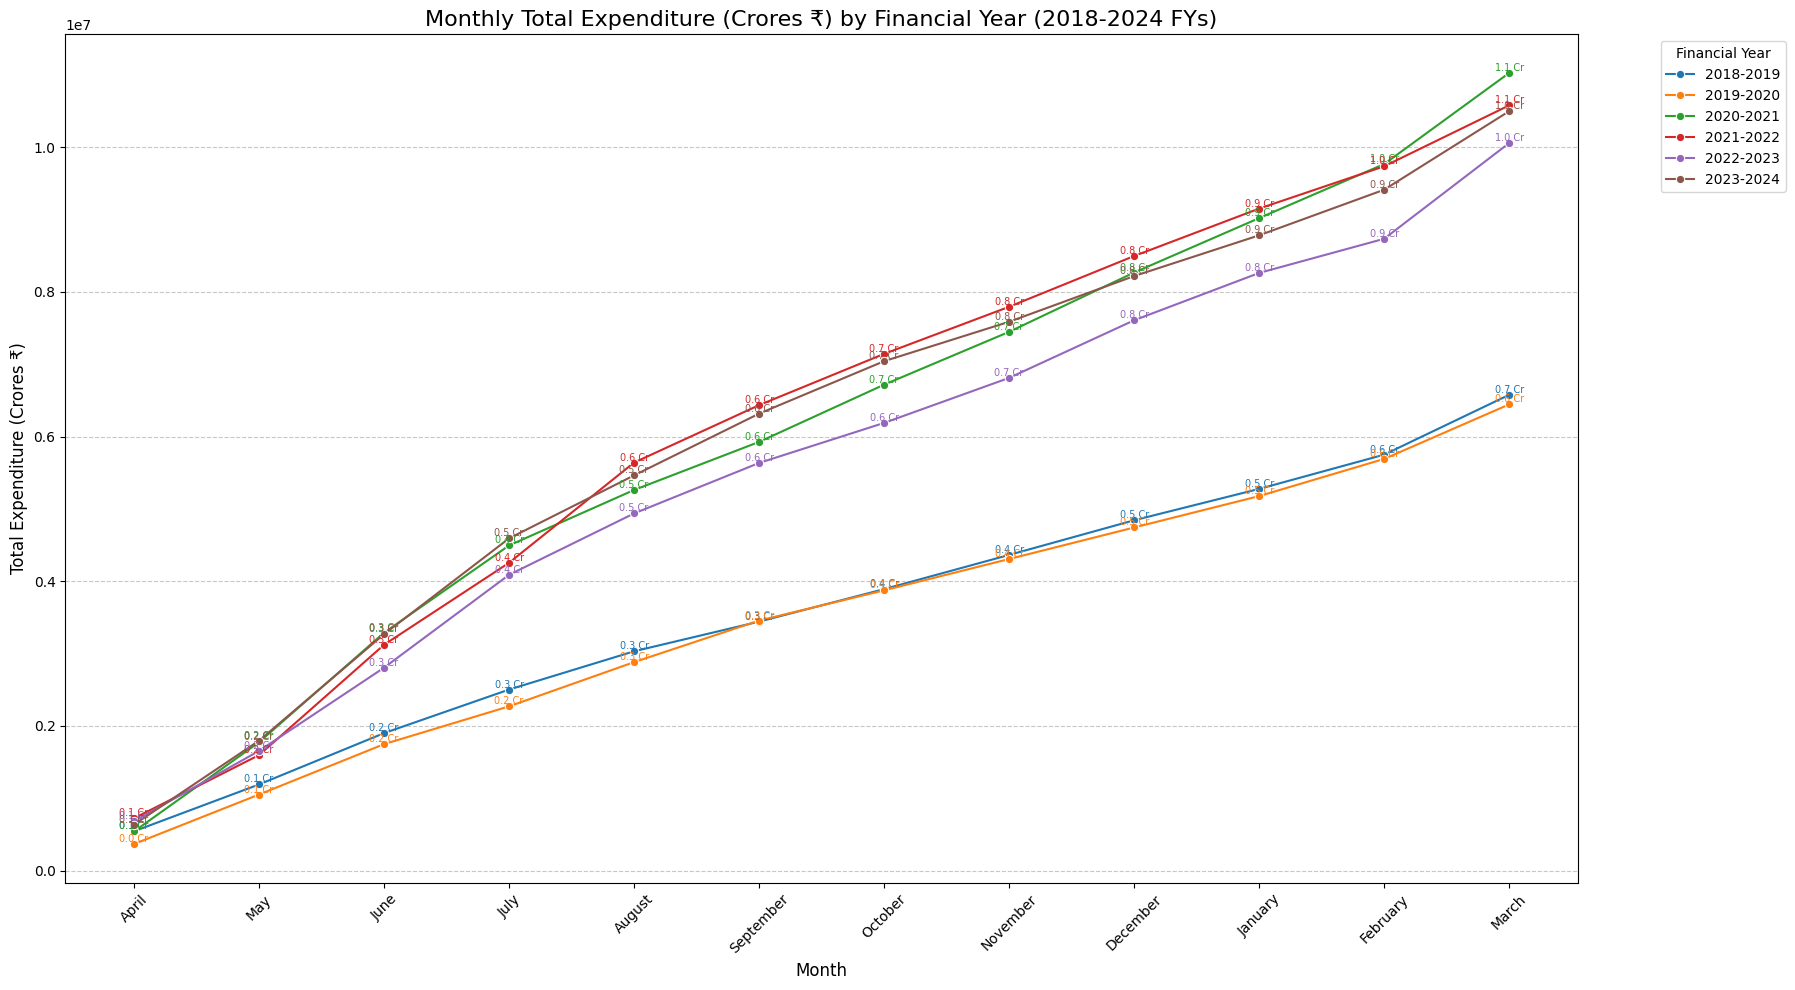

'\nPurpose: To visualize the month-wise trends of total expenditure for each financial year. Excludes anomalous years. Annotated values provide precise figures at each node.\nInsights: Helps in identifying year-specific anomalies or deviations from typical seasonal patterns. Reveals if program scale increased in certain months in specific years.\nInterpretation: For example, a sudden spike in expenditure during a particular month in one year might correspond to specific project rollouts or disaster relief efforts. This granular view helps in understanding yearly operational nuances.\n'

In [57]:

# --- New Visualization: Monthly Trends for Key Metrics by Financial Year ---
print("\n--- Monthly Trends by Financial Year for Key Metrics (2018-2024 FYs) ---") # Updated title

# Data preparation for the new plot: Group by fin_year and calendar_month
df_temp_time['calendar_month_for_plot'] = df_temp_time['month'].astype(str).str.strip().str.title().astype('category')
df_temp_time['calendar_month_for_plot'] = df_temp_time['calendar_month_for_plot'].map(short_to_full_month).fillna(df_temp_time['calendar_month_for_plot'])
df_temp_time['calendar_month_for_plot'] = pd.Categorical(df_temp_time['calendar_month_for_plot'], categories=financial_month_order_for_plot, ordered=True) # Use financial year month order

# Filter out the incomplete 2025-2026 data (already handled by df filtering)
monthly_yearly_trends_filtered = df_temp_time.groupby(['fin_year', 'calendar_month_for_plot']).agg(
    Total_Expenditure=('Total_Exp', 'sum'),
    Total_Workers=('Total_No_of_Workers', 'sum'),
    Avg_Daily_Wage=('Average_Wage_rate_per_day_per_person', 'mean'),
    Avg_100_Days_HH_Ratio=('100_Days_HH_Ratio', 'mean'),
    Avg_Payment_Efficiency=('percentage_payments_gererated_within_15_days', 'mean')
).reset_index().rename(columns={'calendar_month_for_plot': 'Month'})

# Fill NaNs only for numerical columns in this aggregated DataFrame
numerical_cols_for_fill = ['Total_Expenditure', 'Total_Workers', 'Avg_Daily_Wage', 'Avg_100_Days_HH_Ratio', 'Avg_Payment_Efficiency']
for col in numerical_cols_for_fill:
    if col in monthly_yearly_trends_filtered.columns:
        monthly_yearly_trends_filtered[col] = monthly_yearly_trends_filtered[col].fillna(0)


# Plotting for Total Expenditure by Month for Each Year
plt.figure(figsize=(18, 10))
lineplot_exp = sns.lineplot(data=monthly_yearly_trends_filtered, x='Month', y='Total_Expenditure', hue='fin_year', marker='o', palette='tab10')
plt.title('Monthly Total Expenditure (Crores ₹) by Financial Year (2018-2024 FYs)', fontsize=16) # Updated title
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Expenditure (Crores ₹)', fontsize=12)
plt.tick_params(axis='x', rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Financial Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate points for Monthly Total Expenditure
for line in lineplot_exp.get_lines():
    for x_val, y_val in zip(line.get_xdata(), line.get_ydata()):
        if pd.notna(y_val): # Ensure y_val is not NaN
            plt.text(x_val, y_val, f'{y_val/1e7:.1f} Cr', fontsize=7, ha='center', va='bottom', color=line.get_color())

plt.tight_layout()
plt.show()
# Comment for Monthly Total Expenditure by Financial Year
"""
Purpose: To visualize the month-wise trends of total expenditure for each financial year. Excludes anomalous years. Annotated values provide precise figures at each node.
Insights: Helps in identifying year-specific anomalies or deviations from typical seasonal patterns. Reveals if program scale increased in certain months in specific years.
Interpretation: For example, a sudden spike in expenditure during a particular month in one year might correspond to specific project rollouts or disaster relief efforts. This granular view helps in understanding yearly operational nuances.
"""


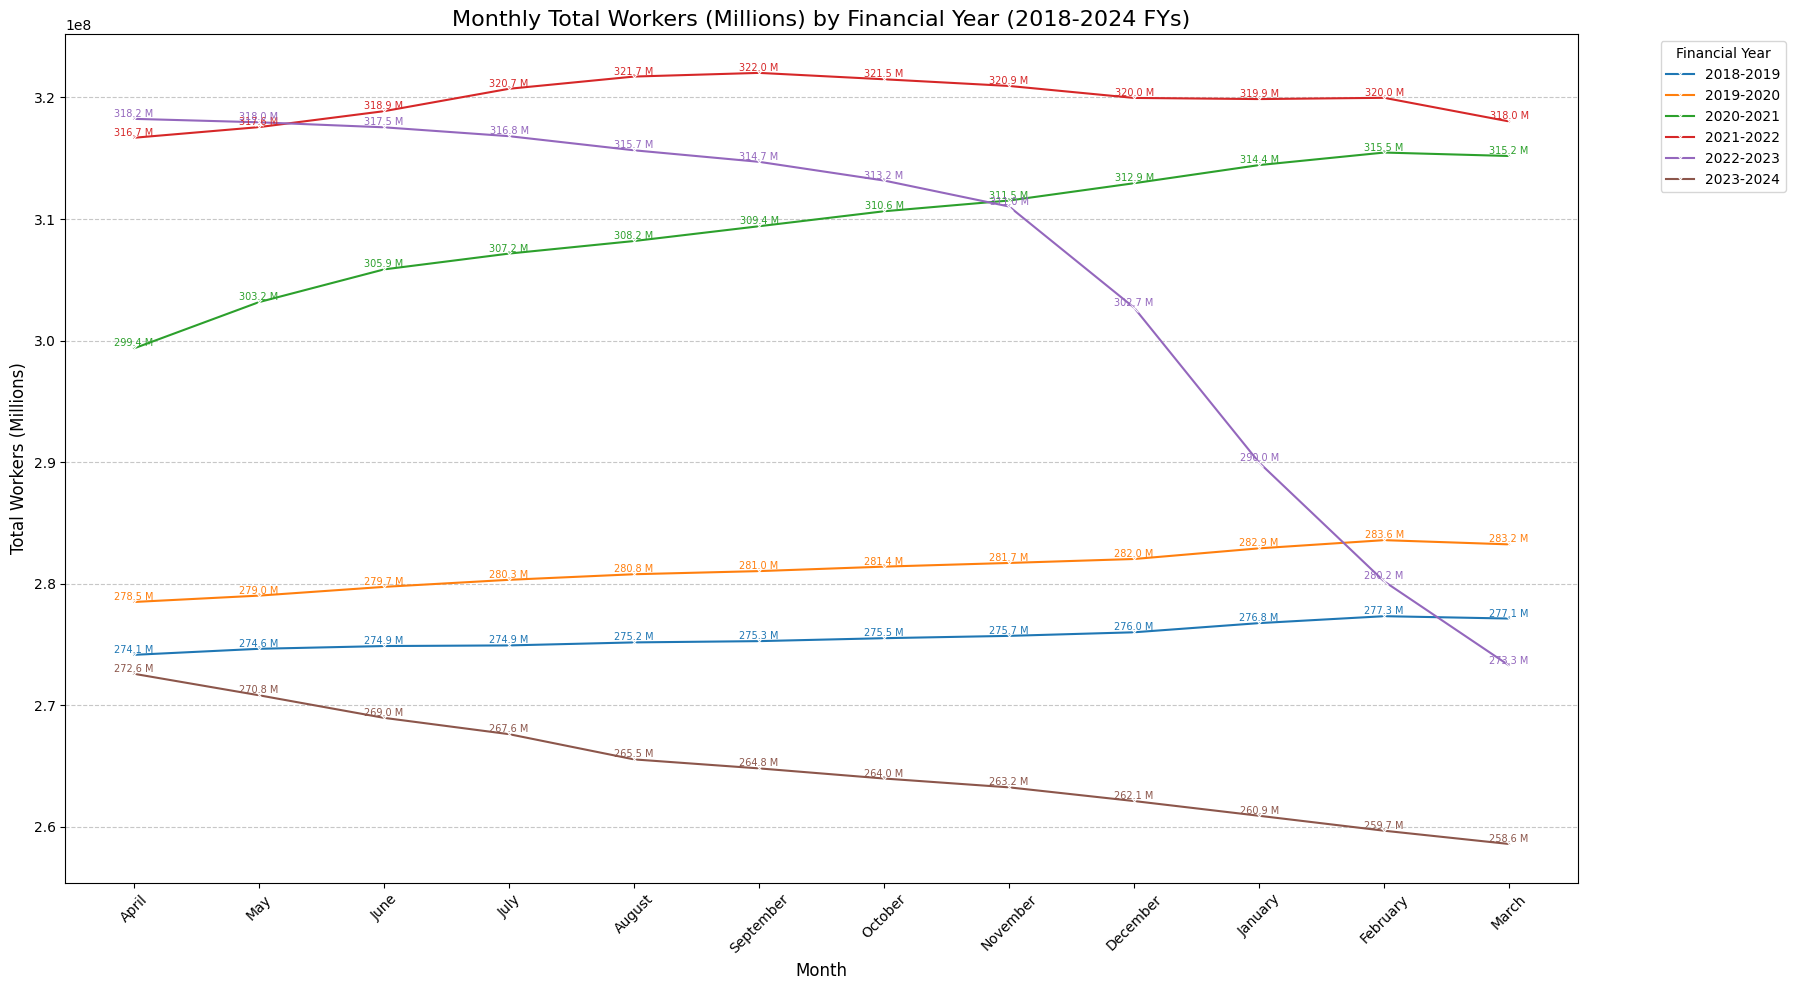

'\nPurpose: To visualize the month-wise trends of total workers employed for each financial year. Excludes anomalous years. Annotated values provide precise figures at each node.\nInsights: Helps in identifying seasonal employment patterns and how they might vary year-on-year.\nInterpretation: Shows how demand for work or availability of projects fluctuates monthly within each financial year. This is vital for understanding employment stability and planning resource allocation.\n'

In [58]:

# Plotting for Total Workers by Month for Each Year
plt.figure(figsize=(18, 10))
lineplot_workers = sns.lineplot(data=monthly_yearly_trends_filtered, x='Month', y='Total_Workers', hue='fin_year', marker='x', palette='tab10')
plt.title('Monthly Total Workers (Millions) by Financial Year (2018-2024 FYs)', fontsize=16) # Updated title
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Workers (Millions)', fontsize=12)
plt.tick_params(axis='x', rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Financial Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate points for Monthly Total Workers
for line in lineplot_workers.get_lines():
    for x_val, y_val in zip(line.get_xdata(), line.get_ydata()):
        if pd.notna(y_val): # Ensure y_val is not NaN
            plt.text(x_val, y_val, f'{y_val/1e6:.1f} M', fontsize=7, ha='center', va='bottom', color=line.get_color())

plt.tight_layout()
plt.show()
# Comment for Monthly Total Workers by Financial Year
"""
Purpose: To visualize the month-wise trends of total workers employed for each financial year. Excludes anomalous years. Annotated values provide precise figures at each node.
Insights: Helps in identifying seasonal employment patterns and how they might vary year-on-year.
Interpretation: Shows how demand for work or availability of projects fluctuates monthly within each financial year. This is vital for understanding employment stability and planning resource allocation.
"""



--- Starting Geospatial Analysis ---
Loaded GeoJSON from: Datasets\GeoJSON\gadm41_IND_2.json
GeoDataFrame columns: ['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2', 'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2', 'geometry']
Successfully dissolved district-level GeoJSON to state boundaries.

States in MGNREGA data: ['ANDAMANANDNICOBAR', 'ANDHRAPRADESH', 'ARUNACHALPRADESH', 'ASSAM', 'BIHAR', 'CHHATTISGARH', 'DNHAVELIANDDD', 'GOA', 'GUJARAT', 'HARYANA', 'HIMACHALPRADESH', 'JAMMUANDKASHMIR', 'JHARKHAND', 'KARNATAKA', 'KERALA', 'LADAKH', 'LAKSHADWEEP', 'MADHYAPRADESH', 'MAHARASHTRA', 'MANIPUR', 'MEGHALAYA', 'MIZORAM', 'NAGALAND', 'ODISHA', 'PUDUCHERRY', 'PUNJAB', 'RAJASTHAN', 'SIKKIM', 'TAMILNADU', 'TELANGANA', 'TRIPURA', 'UTTARAKHAND', 'UTTARPRADESH', 'WESTBENGAL']
States in GeoJSON data: ['ANDAMANANDNICOBAR', 'ANDHRAPRADESH', 'ARUNACHALPRADESH', 'ASSAM', 'BIHAR', 'CHANDIGARH', 'CHHATTISGARH', 'DADRAANDNAGARHAVELI', 'DAMANANDDIU', 'GOA', 'GUJARAT'

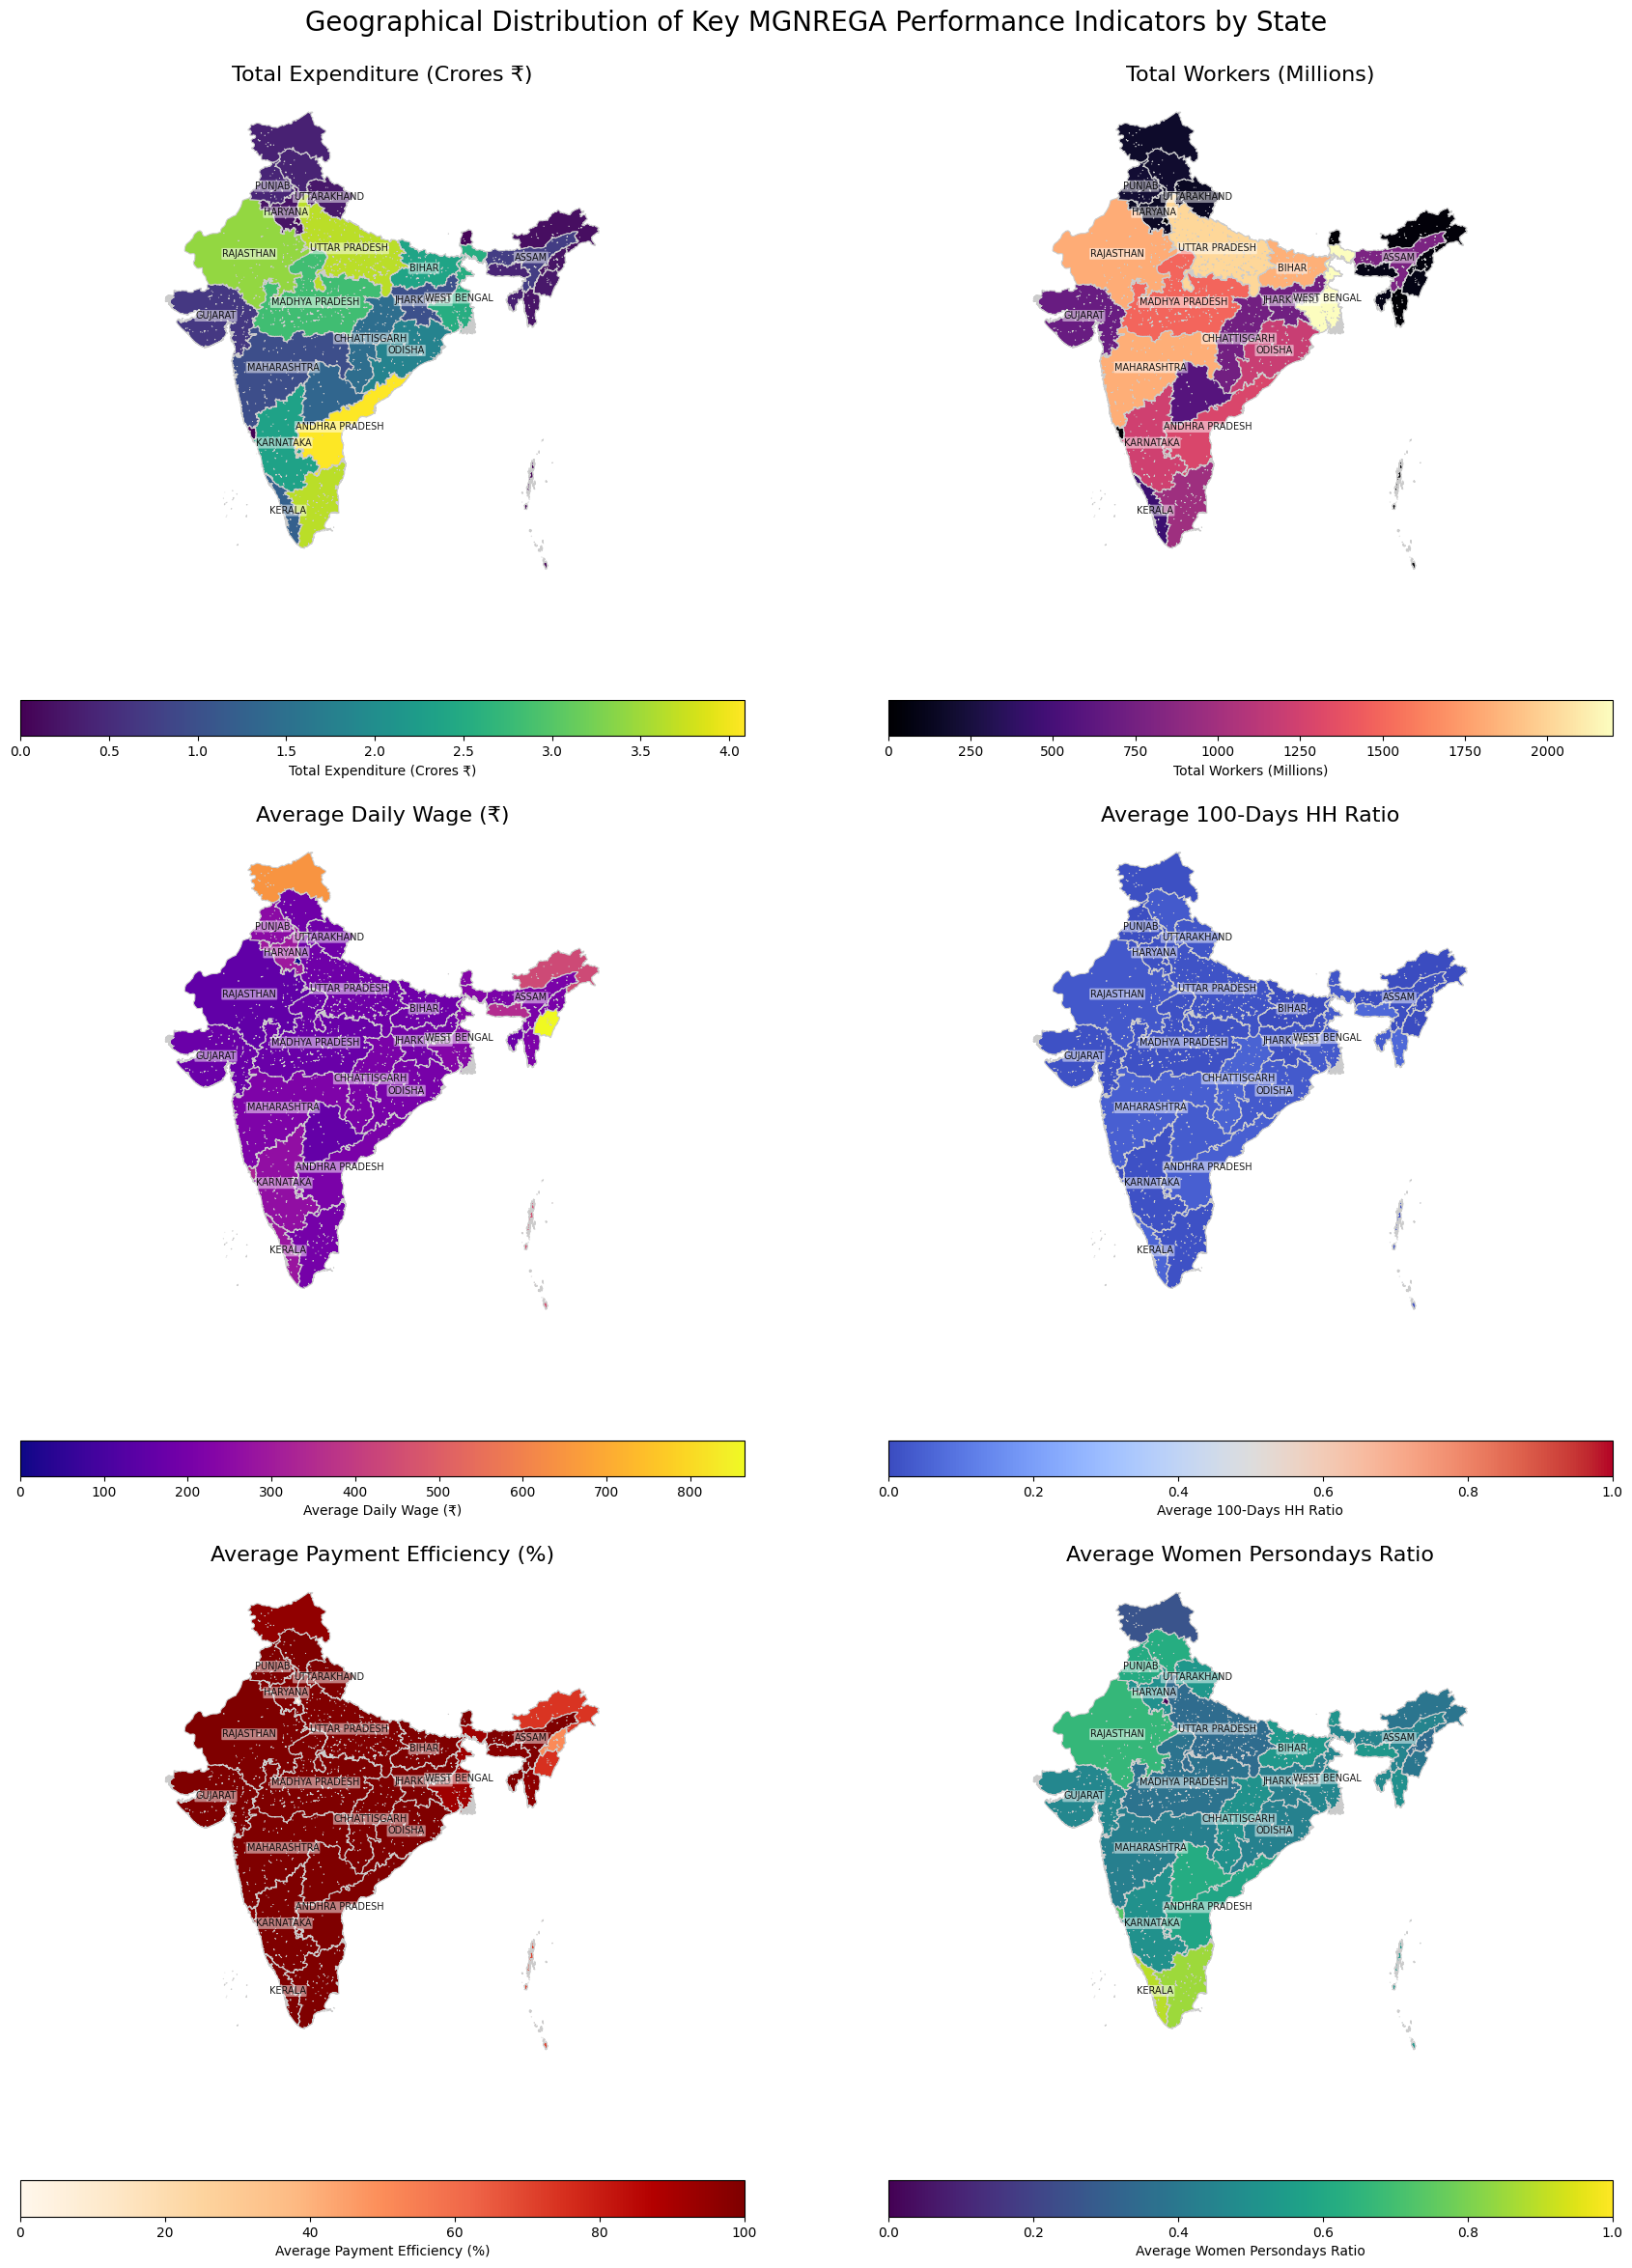


--- Geospatial Analysis Completed ---


In [59]:


# --- Geospatial Analysis (Choropleth Maps) ---
print("\n--- Starting Geospatial Analysis ---")
# Load India's state boundaries
try:
    # IMPORTANT: VERIFY YOUR GEOJSON FILE PATH AND FILENAME!
    if not os.path.exists(GEOJSON_FILE):
        raise FileNotFoundError(f"GeoJSON file not found at: {GEOJSON_FILE}")

    india_states_gdf = geopandas.read_file(GEOJSON_FILE)
    print(f"Loaded GeoJSON from: {GEOJSON_FILE}")
    print(f"GeoDataFrame columns: {india_states_gdf.columns.tolist()}")

    # Check if the loaded GeoJSON is state-level or district-level
    is_state_level_geojson = 'NAME_1' in india_states_gdf.columns and 'NAME_2' not in india_states_gdf.columns
    if not is_state_level_geojson:
        print("Warning: Loaded GeoJSON appears to be district-level or different structure. Attempting to dissolve to state level.")
        if 'NAME_1' in india_states_gdf.columns:
            # Dissolve by NAME_1 to get state boundaries from a district-level file
            india_states_gdf['State_Clean_for_Dissolve'] = india_states_gdf['NAME_1'].astype(str).str.upper().str.replace('&', 'AND').str.replace('.', '').str.replace(' ', '').str.strip()
            india_states_gdf = india_states_gdf.dissolve(by='State_Clean_for_Dissolve')
            # After dissolve, the 'NAME_1' column might become the index or a regular column depending on geopandas version
            if 'State_Clean_for_Dissolve' in india_states_gdf.index.names:
                 india_states_gdf = india_states_gdf.reset_index()
            print("Successfully dissolved district-level GeoJSON to state boundaries.")
        else:
            print("Error: Cannot dissolve GeoJSON to state level. 'NAME_1' column not found. Map plotting might fail or be incorrect.")
            india_states_gdf['State_Clean'] = '' 
    
    # IMPORTANT: Consistent state name cleaning for both GeoDataFrame and aggregated data
    # Standardize names: remove spaces, replace '&' with 'AND', remove dots.
    if 'NAME_1' in india_states_gdf.columns: 
        india_states_gdf['State_Clean'] = india_states_gdf['NAME_1'].astype(str).str.upper().str.replace('&', 'AND').str.replace('.', '').str.replace(' ', '').str.strip()
    elif 'State_Clean_for_Dissolve' in india_states_gdf.columns: 
        india_states_gdf['State_Clean'] = india_states_gdf['State_Clean_for_Dissolve'].astype(str).str.upper().str.replace('&', 'AND').str.replace('.', '').str.replace(' ', '').str.strip()
    elif 'NAME_LOCAL' in india_states_gdf.columns: 
        india_states_gdf['State_Clean'] = india_states_gdf['NAME_LOCAL'].astype(str).str.upper().str.replace('&', 'AND').str.replace('.', '').str.replace(' ', '').str.strip()
    else: 
        print("Warning: Could not find standard state name column in GeoJSON for final cleaning. Merge might fail.")
        india_states_gdf['State_Clean'] = india_states_gdf.index.astype(str).str.upper().str.replace('&', 'AND').str.replace('.', '').str.replace(' ', '').str.strip()


    state_performance_reset = state_performance.reset_index()
    state_performance_reset['State_Clean'] = state_performance_reset['State'].astype(str).str.upper().str.replace('&', 'AND').str.replace('.', '').str.replace(' ', '').str.strip()

    # Debugging state name mismatches
    mgnrega_states = set(state_performance_reset['State_Clean'].unique())
    geojson_states = set(india_states_gdf['State_Clean'].unique())

    print(f"\nStates in MGNREGA data: {sorted(list(mgnrega_states))}")
    print(f"States in GeoJSON data: {sorted(list(geojson_states))}")
    print(f"States in MGNREGA but not in GeoJSON: {mgnrega_states - geojson_states}")
    print(f"States in GeoJSON but not in MGNREGA: {geojson_states - mgnrega_states}")
    
    common_states = list(mgnrega_states.intersection(geojson_states))
    if not common_states:
        print("Warning: No common states found between MGNREGA data and GeoJSON. Map plotting might be empty or incorrect.")
        print("This is often due to naming inconsistencies. Please review the 'States in MGNREGA data' and 'States in GeoJSON data' lists above.")

    merged_gdf = india_states_gdf.merge(state_performance_reset, left_on='State_Clean', right_on='State_Clean', how='left')

    for col in state_performance.columns:
        if col in merged_gdf.columns: 
            if merged_gdf[col].isnull().any():
                merged_gdf[col] = merged_gdf[col].fillna(0) 


    # Plot Choropleth Maps for key metrics
    fig, axes = plt.subplots(3, 2, figsize=(20, 25))
    fig.suptitle('Geographical Distribution of Key MGNREGA Performance Indicators by State', fontsize=20)

    map_metrics = [
        ('Total_Expenditure', 'Total Expenditure (Crores ₹)', plt.cm.viridis),
        ('Total_Workers', 'Total Workers (Millions)', plt.cm.magma),
        ('Avg_Daily_Wage', 'Average Daily Wage (₹)', plt.cm.plasma),
        ('Avg_100_Days_HH_Ratio', 'Average 100-Days HH Ratio', plt.cm.coolwarm),
        ('Avg_Payment_Efficiency', 'Average Payment Efficiency (%)', plt.cm.OrRd),
        ('Avg_Women_Persondays_Ratio', 'Average Women Persondays Ratio', plt.cm.viridis)
    ]

    axes = axes.flatten()

    for i, (metric, title, cmap) in enumerate(map_metrics):
        ax = axes[i]
        plot_data = merged_gdf[metric]
        if 'Expenditure' in title:
            plot_data = plot_data / 1e7 
        elif 'Workers' in title:
            plot_data = plot_data / 1e6 

        vmin, vmax = None, None
        if 'Ratio' in title or 'Percentage' in title:
            vmin = 0
            vmax = 1.0 if 'Ratio' in title else 100.0
        
        # Ensure plot_data has non-NaN values for mapping, fill with 0 if needed for states with no data
        plot_data_for_map = plot_data.fillna(0) # Temporarily fill for plotting color, missing_kwds still takes over for legend

        merged_gdf.plot(column=plot_data_for_map, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
                        legend_kwds={'label': title, 'orientation': "horizontal", 'shrink': 0.7}, 
                        missing_kwds={"color": "lightgrey", "label": "No Data"},
                        vmin=vmin, vmax=vmax 
                        )
        
        ax.set_title(title, fontsize=16)
        ax.set_axis_off() 

        # Add state names as text labels (selectively for larger states for clarity)
        # Use merged_gdf['State'] for original state names if available
        for idx, row in merged_gdf.iterrows():
            # Only label states that have data and are large enough for the label to be clear
            # Filter for larger states or states with more central geometry to avoid clutter
            if pd.notna(row[metric]) and row[metric] > 0 and row['State_Clean'] in common_states: 
                # Heuristic for selective labeling on India map to prevent clutter
                if row['State_Clean'] in ['UTTARPRADESH', 'MADHYAPRADESH', 'RAJASTHAN', 'MAHARASHTRA', 
                                          'ANDHRAPRADESH', 'KARNATAKA', 'GUJARAT', 'ODISHA', 
                                          'CHHATTISGARH', 'WESTBENGAL', 'BIHAR', 'ASSAM', 'KERALA',
                                          'PUNJAB', 'HARYANA', 'JHARKHAND', 'UTTARAKHAND']:
                    try:
                        centroid = row.geometry.centroid
                        # Adjust text properties based on expected background color from colormap or general contrast
                        # For viridis/magma/plasma, black text is generally good. For OrRd, black/dark color needed.
                        ax.text(centroid.x, centroid.y, row['State'], fontsize=7, ha='center', va='center', color='black', alpha=0.9,
                               bbox=dict(boxstyle="round,pad=0.1", fc='white', ec='none', alpha=0.5)) # Add bbox for readability
                    except Exception as e:
                        print(f"Could not add label for {row['State']}: {e}")


    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
    print("\n--- Geospatial Analysis Completed ---")

except FileNotFoundError:
    print(f"Error: GeoJSON file '{GEOJSON_FILE}' not found. Skipping geospatial analysis.")
    print("Please ensure you have the GeoJSON file for Indian administrative boundaries in the specified path.")
    print("Example: ML_CA1/Datasets/GeoJSON/gadm41_IND_1.json (for states) or gadm41_IND_2.json (if you want to dissolve districts to states).")
except Exception as e:
    print(f"An unexpected error occurred during geospatial analysis: {e}")
    print("Skipping geospatial analysis. Error details:")
    import traceback
    traceback.print_exc()




--- Correlation Matrix of Key Numerical Metrics ---


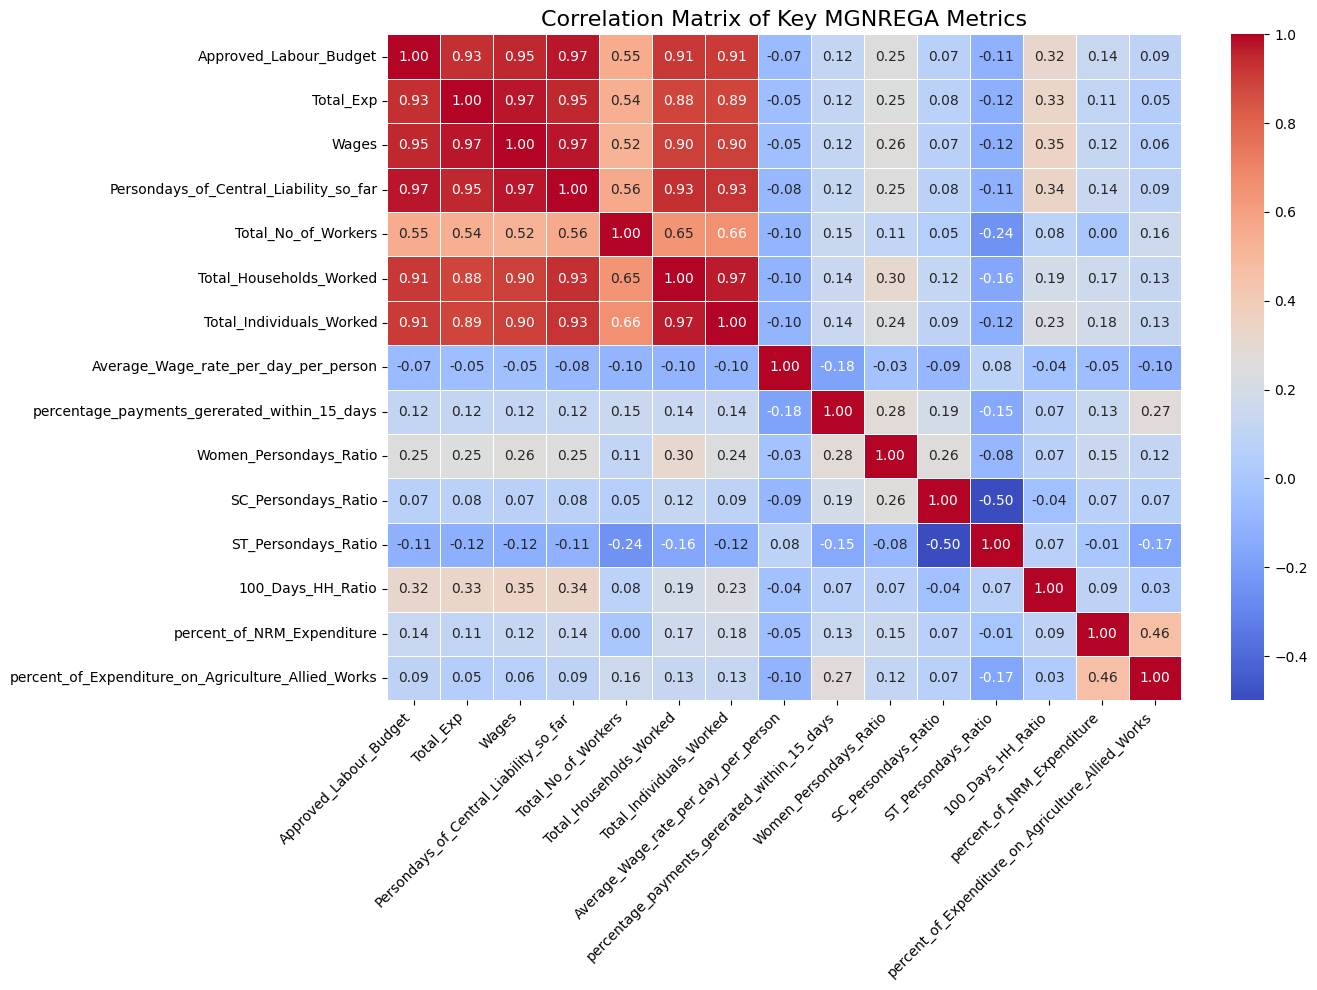


--- EDA Step 3 Completed. Dataset is ready for in-depth analysis and insights. ---


In [60]:

# --- Bivariate Analysis: Correlation Matrix ---
print("\n--- Correlation Matrix of Key Numerical Metrics ---")
correlation_cols = [
    'Approved_Labour_Budget', 'Total_Exp', 'Wages', 'Persondays_of_Central_Liability_so_far',
    'Total_No_of_Workers', 'Total_Households_Worked', 'Total_Individuals_Worked',
    'Average_Wage_rate_per_day_per_person', 'percentage_payments_gererated_within_15_days',
    'Women_Persondays_Ratio', 'SC_Persondays_Ratio', 'ST_Persondays_Ratio',
    '100_Days_HH_Ratio', 'percent_of_NRM_Expenditure', 'percent_of_Expenditure_on_Agriculture_Allied_Works'
]

correlation_matrix = df[correlation_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key MGNREGA Metrics', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
# Comment for Correlation Matrix
"""
Purpose: To quantitatively assess the linear relationships between various key numerical metrics.
Insights: High correlation (close to +1 or -1) indicates that two variables tend to move together or in opposite directions.
Interpretation: For instance, a strong positive correlation between 'Total_Exp' and 'Total_Workers' would indicate that higher spending leads to more employment. This helps identify interdependencies and potential drivers for different aspects of the scheme. Weak correlations might suggest that metrics are independent, or that non-linear relationships exist.
"""

print("\n--- EDA Step 3 Completed. Dataset is ready for in-depth analysis and insights. ---")


In [13]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# geopandas is not strictly necessary for single-district temporal trends,
# but keeping for completeness if future geospatial desires emerge.
# import geopandas

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# --- Configuration for File Paths ---
# Assuming the project root is where your main script runs from (e.g., 'ML_CA1')
PROJECT_ROOT = ""
CLEANED_DATA_DIR = os.path.join(PROJECT_ROOT, "Datasets", "Cleaned_Preprocessed")
# This is the CSV file containing the overall data, filtered for historical consistency
INPUT_DATA_FILE = os.path.join(CLEANED_DATA_DIR, "mgnrega_data_filtered_for_analysis.csv")

# --- Step 1: Load Data and Filter for Nagpur District ---
print("--- Starting Focused Analysis of Nagpur District ---")
print("\n--- Step 1: Loading Data and Filtering for Nagpur District ---")
try:
    df_raw = pd.read_csv(INPUT_DATA_FILE)
    print(f"Loaded filtered data from: {INPUT_DATA_FILE}")
    print(f"Initial DataFrame shape: {df_raw.shape}")
except FileNotFoundError:
    print(f"Error: Input data file '{INPUT_DATA_FILE}' not found. Please ensure the path is correct.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    exit()

# Filter for Nagpur district only (ensure exact spelling matches your data)
NAGPUR_DISTRICT_NAME = 'NAGPUR' # Assuming 'NAGPUR' is the exact district name in your 'District' column
df_nagpur = df_raw[df_raw['District'] == NAGPUR_DISTRICT_NAME].copy()

if df_nagpur.empty:
    print(f"Error: No data found for district '{NAGPUR_DISTRICT_NAME}'. Please check the district name or your input data file.")
    print(f"Available districts: {df_raw['District'].unique()}")
    exit()

print(f"Filtered data for Nagpur district. Shape: {df_nagpur.shape}")
print(f"Financial years included for Nagpur: {df_nagpur['fin_year'].unique()}")



--- Starting Focused Analysis of Nagpur District ---

--- Step 1: Loading Data and Filtering for Nagpur District ---
Loaded filtered data from: Datasets\Cleaned_Preprocessed\mgnrega_data_filtered_for_analysis.csv
Initial DataFrame shape: (50892, 36)
Filtered data for Nagpur district. Shape: (72, 36)
Financial years included for Nagpur: ['2018-2019' '2019-2020' '2020-2021' '2021-2022' '2022-2023' '2023-2024']


In [14]:

# --- Step 2: Feature Engineering and Temporal Key Derivation (for Nagpur Subset) ---
print("\n--- Step 2: Feature Engineering and Temporal Key Derivation for Nagpur ---")

# Define month order for Indian Financial Year (April to March)
FINANCIAL_MONTH_ORDER = ['April', 'May', 'June', 'July', 'August', 'September', 
                         'October', 'November', 'December', 'January', 'February', 'March']

# Robust mapping for month names (handles short forms too)
MONTH_TO_NUM_FOR_FY = {
    'April': 0, 'May': 1, 'June': 2, 'July': 3, 'August': 4, 'September': 5, 
    'October': 6, 'November': 7, 'December': 8, 'January': 9, 'February': 10, 'March': 11,
    'Apr': 0, 'May': 1, 'Jun': 2, 'Jul': 3, 'Aug': 4, 'Sep': 5, 
    'Oct': 6, 'Nov': 7, 'Dec': 8, 'Jan': 9, 'Feb': 10, 'Mar': 11
}

# 2.1: Temporal Keys for Sorting and Aggregation
df_nagpur['month_processed'] = df_nagpur['month'].astype(str).str.strip().str.title()
df_nagpur['month_full_name'] = df_nagpur['month_processed'].apply(lambda x: next((m_full for m_full in FINANCIAL_MONTH_ORDER if m_full.startswith(x)), x))
df_nagpur['month_num_fy_order'] = df_nagpur['month_full_name'].map(MONTH_TO_NUM_FOR_FY)
df_nagpur['start_year_temp'] = df_nagpur['fin_year'].astype(str).str.split('-').str[0].astype(int)

# Drop rows with NaNs in temporal keys (should be minimal)
df_nagpur.dropna(subset=['month_num_fy_order', 'start_year_temp'], inplace=True) 


# 2.2: Engineered Ratio Features
df_nagpur['Women_Persondays_Ratio'] = df_nagpur['Women_Persondays'] / df_nagpur['Persondays_of_Central_Liability_so_far']
df_nagpur['Women_Persondays_Ratio'] = df_nagpur['Women_Persondays_Ratio'].replace([np.inf, -np.inf], np.nan).fillna(0) 
df_nagpur['Women_Persondays_Ratio'] = np.clip(df_nagpur['Women_Persondays_Ratio'], 0, 1) 

df_nagpur['SC_Persondays_Ratio'] = df_nagpur['SC_persondays'] / df_nagpur['Persondays_of_Central_Liability_so_far']
df_nagpur['SC_Persondays_Ratio'] = df_nagpur['SC_Persondays_Ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)
df_nagpur['SC_Persondays_Ratio'] = np.clip(df_nagpur['SC_Persondays_Ratio'], 0, 1)

df_nagpur['ST_Persondays_Ratio'] = df_nagpur['ST_persondays'] / df_nagpur['Persondays_of_Central_Liability_so_far']
df_nagpur['ST_Persondays_Ratio'] = df_nagpur['ST_Persondays_Ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)
df_nagpur['ST_Persondays_Ratio'] = np.clip(df_nagpur['ST_Persondays_Ratio'], 0, 1)

df_nagpur['100_Days_HH_Ratio'] = df_nagpur['Total_No_of_HHs_completed_100_Days_of_Wage_Employment'] / df_nagpur['Total_Households_Worked']
df_nagpur['100_Days_HH_Ratio'] = df_nagpur['100_Days_HH_Ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)
df_nagpur['100_Days_HH_Ratio'] = np.clip(df_nagpur['100_Days_HH_Ratio'], 0, 1)

print("Feature engineering and temporal keys successfully derived for Nagpur data.")

# Convert relevant columns to categorical for efficiency
df_nagpur['fin_year'] = df_nagpur['fin_year'].astype('category')
df_nagpur['month_full_name'] = pd.Categorical(df_nagpur['month_full_name'], categories=FINANCIAL_MONTH_ORDER, ordered=True)

# Drop redundant temp columns
df_nagpur.drop(columns=['month_processed'], inplace=True, errors='ignore')




--- Step 2: Feature Engineering and Temporal Key Derivation for Nagpur ---
Feature engineering and temporal keys successfully derived for Nagpur data.


In [15]:

# --- Step 3: Initial Data Overview for Nagpur ---
print("\n--- Step 3: Initial Data Overview for Nagpur ---")
print(df_nagpur.info())
print("\n--- Sample Data for Nagpur (Head) ---")
print(df_nagpur.head())


--- Step 3: Initial Data Overview for Nagpur ---
<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 318 to 50491
Data columns (total 43 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   fin_year                                               72 non-null     category
 1   month                                                  72 non-null     object  
 2   state_code                                             72 non-null     int64   
 3   State                                                  72 non-null     object  
 4   district_code                                          72 non-null     int64   
 5   District                                               72 non-null     object  
 6   Approved_Labour_Budget                                 72 non-null     float64 
 7   Average_Wage_rate_per_day_per_person                   72 non-null     float6

In [2]:
print("\n--- Descriptive Statistics for Numerical Features in Nagpur ---")
numerical_cols_nagpur = df_nagpur.select_dtypes(include=np.number).columns.tolist()
desc_stats_nagpur = df_nagpur[numerical_cols_nagpur].describe().T
print(desc_stats_nagpur)

print("\n--- Count of Zero Values in Key Numerical Columns for Nagpur ---")
for col in ['Total_Exp', 'Total_No_of_Workers', 'Approved_Labour_Budget', 'Average_Wage_rate_per_day_per_person', '100_Days_HH_Ratio']:
    if col in df_nagpur.columns:
        num_zeros = (df_nagpur[col] == 0).sum()
        if num_zeros > 0:
            print(f"'{col}': {num_zeros} zeros ({num_zeros/len(df_nagpur)*100:.2f}%)")




--- Descriptive Statistics for Numerical Features in Nagpur ---
                                                    count          mean  \
state_code                                           72.0  1.800000e+01   
district_code                                        72.0  1.827000e+03   
Approved_Labour_Budget                               72.0  1.373898e+06   
Average_Wage_rate_per_day_per_person                 72.0  2.124429e+02   
Average_days_of_employment_provided_per_Household    72.0  3.295833e+01   
Differently_abled_persons_worked                     72.0  2.764861e+02   
Material_and_skilled_Wages                           72.0  7.214092e+02   
Number_of_Completed_Works                            72.0  4.445111e+03   
Number_of_GPs_with_NIL_exp                           72.0  5.365278e+01   
Number_of_Ongoing_Works                              72.0  1.396217e+04   
Persondays_of_Central_Liability_so_far               72.0  1.222986e+06   
SC_persondays                      

In [3]:
# --- Step 4: Temporal Trend Analysis for Nagpur District ---
print("\n--- Step 4: Analyzing Temporal Trends for Nagpur District ---")

# Aggregation for Yearly Trends for Nagpur
nagpur_yearly_trends = df_nagpur.groupby('fin_year').agg(
    Total_Expenditure=('Total_Exp', 'sum'),
    Total_Workers=('Total_No_of_Workers', 'sum'),
    Avg_Daily_Wage=('Average_Wage_rate_per_day_per_person', 'mean'),
    Avg_100_Days_HH_Ratio=('100_Days_HH_Ratio', 'mean'),
    Avg_Payment_Efficiency=('percentage_payments_gererated_within_15_days', 'mean')
).sort_values(by='fin_year')

print("\nNagpur Yearly Trends (Overall):")
print(nagpur_yearly_trends)


--- Step 4: Analyzing Temporal Trends for Nagpur District ---

Nagpur Yearly Trends (Overall):
           Total_Expenditure  Total_Workers  Avg_Daily_Wage  \
fin_year                                                      
2018-2019       36003.984988      4745290.0      181.600677   
2019-2020       28644.668042      4883713.0      189.068795   
2020-2021       39765.555917      5215388.0      205.880322   
2021-2022       44870.125487      5794989.0      228.033867   
2022-2023       62695.221362      6082520.0      227.957119   
2023-2024       46885.836807      6276155.0      242.116466   

           Avg_100_Days_HH_Ratio  Avg_Payment_Efficiency  
fin_year                                                  
2018-2019               0.066915               99.999167  
2019-2020               0.064969              100.000000  
2020-2021               0.070508               99.996667  
2021-2022               0.051067              100.000000  
2022-2023               0.046105             

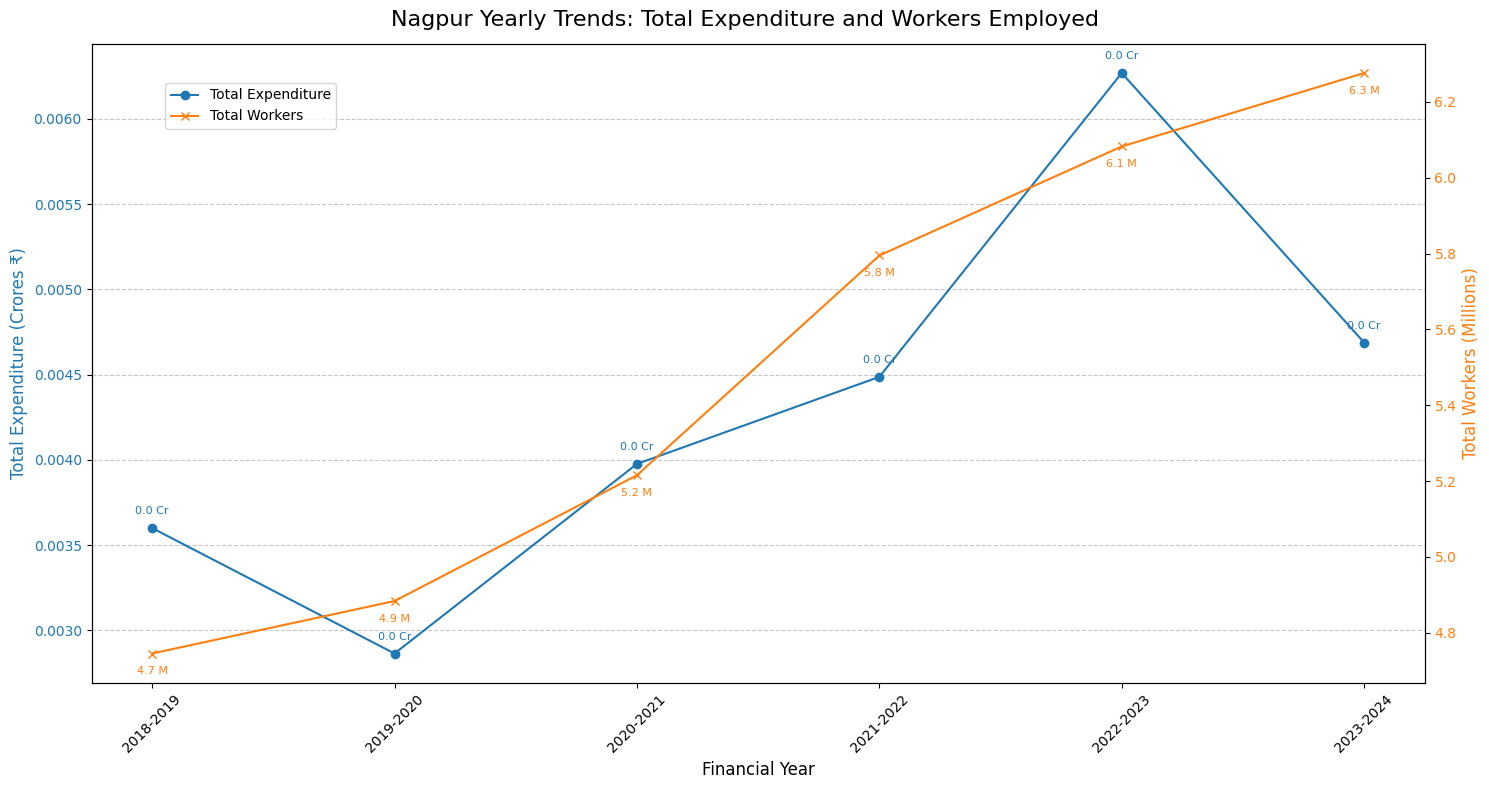

"\nPurpose: To visualize overall trends of expenditure and employment under MGNREGA specifically for Nagpur district.\nInsights: Provides insight into Nagpur's long-term commitment and activity levels in the scheme.\nInterpretation: An increasing trend indicates program expansion, while a decline might signal reduced demand or implementation challenges specific to Nagpur.\n"

In [4]:
# Plotting Overall Nagpur Yearly Trends
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot Total Expenditure
color = 'tab:blue'
ax1.set_xlabel('Financial Year', fontsize=12)
ax1.set_ylabel('Total Expenditure (Crores ₹)', color=color, fontsize=12)
line1 = ax1.plot(nagpur_yearly_trends.index, nagpur_yearly_trends['Total_Expenditure'] / 1e7, color=color, marker='o', label='Total Expenditure')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45) 
ax1.grid(axis='y', linestyle='--', alpha=0.7) 
for x, y in zip(nagpur_yearly_trends.index, nagpur_yearly_trends['Total_Expenditure'] / 1e7):
    ax1.annotate(f'{y:.1f} Cr', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color=color)

# Plot Total Workers on a twin axis
ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('Total Workers (Millions)', color=color, fontsize=12)
line2 = ax2.plot(nagpur_yearly_trends.index, nagpur_yearly_trends['Total_Workers'] / 1e6, color=color, marker='x', label='Total Workers')
ax2.tick_params(axis='y', labelcolor=color)
for x, y in zip(nagpur_yearly_trends.index, nagpur_yearly_trends['Total_Workers'] / 1e6):
    ax2.annotate(f'{y:.1f} M', (x, y), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color=color)

fig.suptitle('Nagpur Yearly Trends: Total Expenditure and Workers Employed', fontsize=16)
lines_combined = line1 + line2
labels_combined = [l.get_label() for l in lines_combined]
ax2.legend(lines_combined, labels_combined, loc='upper left', bbox_to_anchor=(0.05, 0.95))
fig.tight_layout()
plt.show()
"""
Purpose: To visualize overall trends of expenditure and employment under MGNREGA specifically for Nagpur district.
Insights: Provides insight into Nagpur's long-term commitment and activity levels in the scheme.
Interpretation: An increasing trend indicates program expansion, while a decline might signal reduced demand or implementation challenges specific to Nagpur.
"""

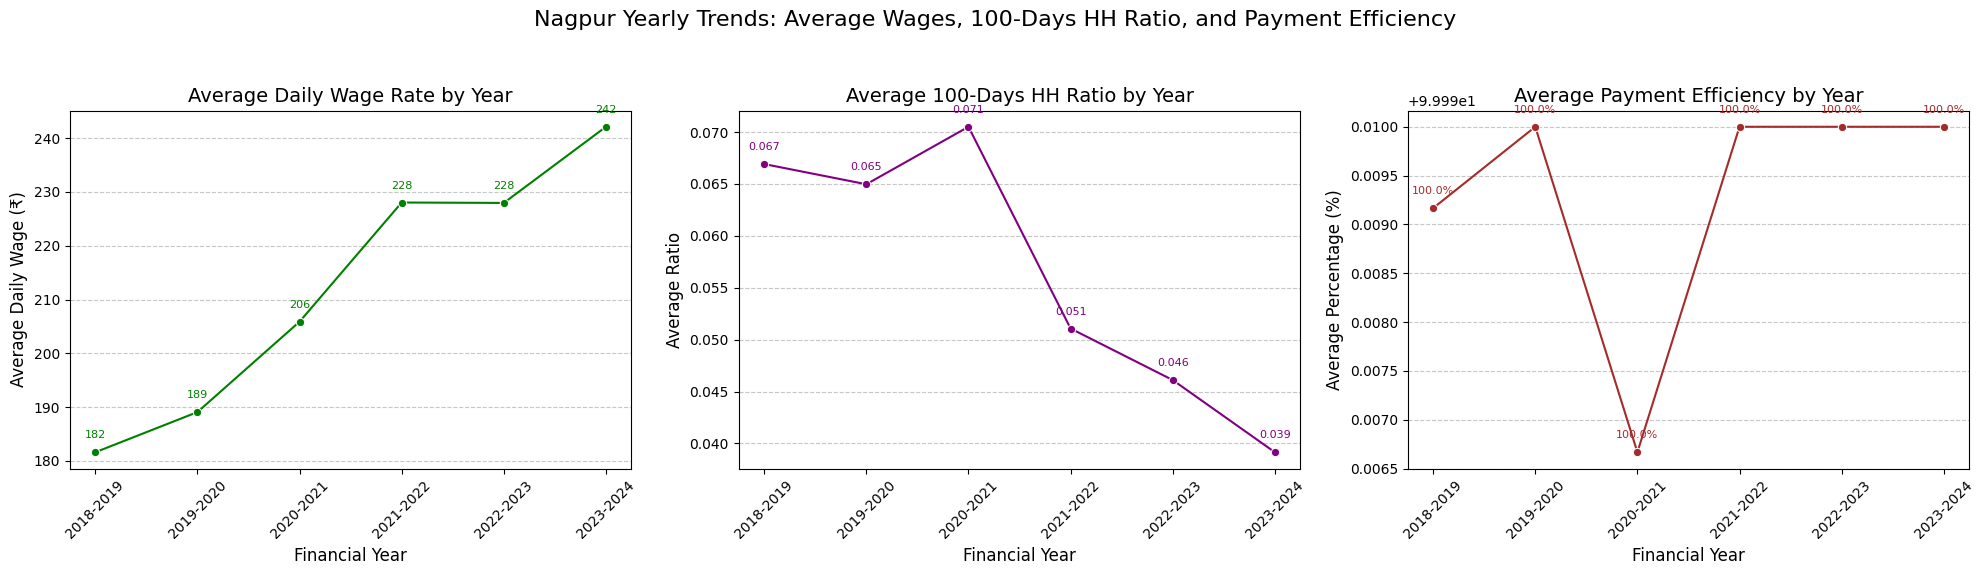

In [6]:
# Separate plots for other yearly trends for Nagpur
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Nagpur Yearly Trends: Average Wages, 100-Days HH Ratio, and Payment Efficiency', fontsize=16)

# Plot Avg_Daily_Wage by Year
sns.lineplot(x=nagpur_yearly_trends.index, y='Avg_Daily_Wage', data=nagpur_yearly_trends, marker='o', ax=axes[0], color='green')
axes[0].set_title('Average Daily Wage Rate by Year', fontsize=14)
axes[0].set_xlabel('Financial Year', fontsize=12)
axes[0].set_ylabel('Average Daily Wage (₹)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for x, y in zip(nagpur_yearly_trends.index, nagpur_yearly_trends['Avg_Daily_Wage']):
    axes[0].annotate(f'{y:.0f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='green')
"""
Purpose: To track the trend of average daily wages provided under MGNREGA in Nagpur over time.
Insights: Shows whether worker income is increasing or stagnating in Nagpur.
Interpretation: A consistent upward trend is a positive sign for improving livelihood standards. Any stagnation or decrease would warrant concern and policy review specific to Nagpur.
"""

# Plot Avg_100_Days_HH_Ratio by Year
sns.lineplot(x=nagpur_yearly_trends.index, y='Avg_100_Days_HH_Ratio', data=nagpur_yearly_trends, marker='o', ax=axes[1], color='purple')
axes[1].set_title('Average 100-Days HH Ratio by Year', fontsize=14)
axes[1].set_xlabel('Financial Year', fontsize=12)
axes[1].set_ylabel('Average Ratio', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
for x, y in zip(nagpur_yearly_trends.index, nagpur_yearly_trends['Avg_100_Days_HH_Ratio']):
    axes[1].annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='purple')
"""
Purpose: To understand the longitudinal effectiveness of providing the full 100 days of guaranteed work in Nagpur.
Insights: Reveals the scheme's success in delivering its core promise locally. Low or declining trends highlight challenges.
Interpretation: Observed trends in this ratio are critical for policy attention in Nagpur, suggesting whether households are receiving the full guarantee.
"""

# Plot Avg_Payment_Efficiency by Year
sns.lineplot(x=nagpur_yearly_trends.index, y='Avg_Payment_Efficiency', data=nagpur_yearly_trends, marker='o', ax=axes[2], color='brown')
axes[2].set_title('Average Payment Efficiency by Year', fontsize=14)
axes[2].set_xlabel('Financial Year', fontsize=12)
axes[2].set_ylabel('Average Percentage (%)', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
for x, y in zip(nagpur_yearly_trends.index, nagpur_yearly_trends['Avg_Payment_Efficiency']):
    axes[2].annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='brown')
"""
Purpose: To monitor the efficiency of wage disbursement in Nagpur over financial years.
Insights: Timely payments are crucial for worker welfare. A high and stable percentage is ideal.
Interpretation: Observed efficiency trends are critical for understanding administrative performance in Nagpur. Any dips warrant investigation, as payment delays can severely impact the financial stability of workers.
"""

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [7]:
# Monthly trends (considering all years for seasonality for Nagpur)
print("\n--- Monthly Trends for Nagpur (Aggregated Across All Years) ---")

nagpur_monthly_trends = df_nagpur.groupby('month_full_name').agg(
    Total_Expenditure=('Total_Exp', 'sum'),
    Total_Workers=('Total_No_of_Workers', 'sum'),
    Avg_Daily_Wage=('Average_Wage_rate_per_day_per_person', 'mean'),
    Avg_100_Days_HH_Ratio=('100_Days_HH_Ratio', 'mean'), 
    Avg_Payment_Efficiency=('percentage_payments_gererated_within_15_days', 'mean')
).reindex(FINANCIAL_MONTH_ORDER) # Order months for consistent plotting

nagpur_monthly_trends = nagpur_monthly_trends.fillna(0) # Fill NaNs for plotting


print("\nNagpur Monthly Trends (Aggregated Across All Years):")
print(nagpur_monthly_trends)


--- Monthly Trends for Nagpur (Aggregated Across All Years) ---

Nagpur Monthly Trends (Aggregated Across All Years):
                 Total_Expenditure  Total_Workers  Avg_Daily_Wage  \
month_full_name                                                     
April                  1797.115563      2693376.0      153.728563   
May                    5381.415204      2703539.0      173.545886   
June                   9404.866004      2712227.0      200.540204   
July                  13595.653277      2721680.0      214.687457   
August                17025.225160      2726478.0      220.551309   
September             19753.344536      2741670.0      221.886354   
October               24116.570366      2756815.0      223.605294   
November              26908.565972      2766415.0      224.058869   
December              30116.859184      2777625.0      224.576597   
January               32986.434230      2790593.0      224.978947   
February              35826.356791      2799678.0    

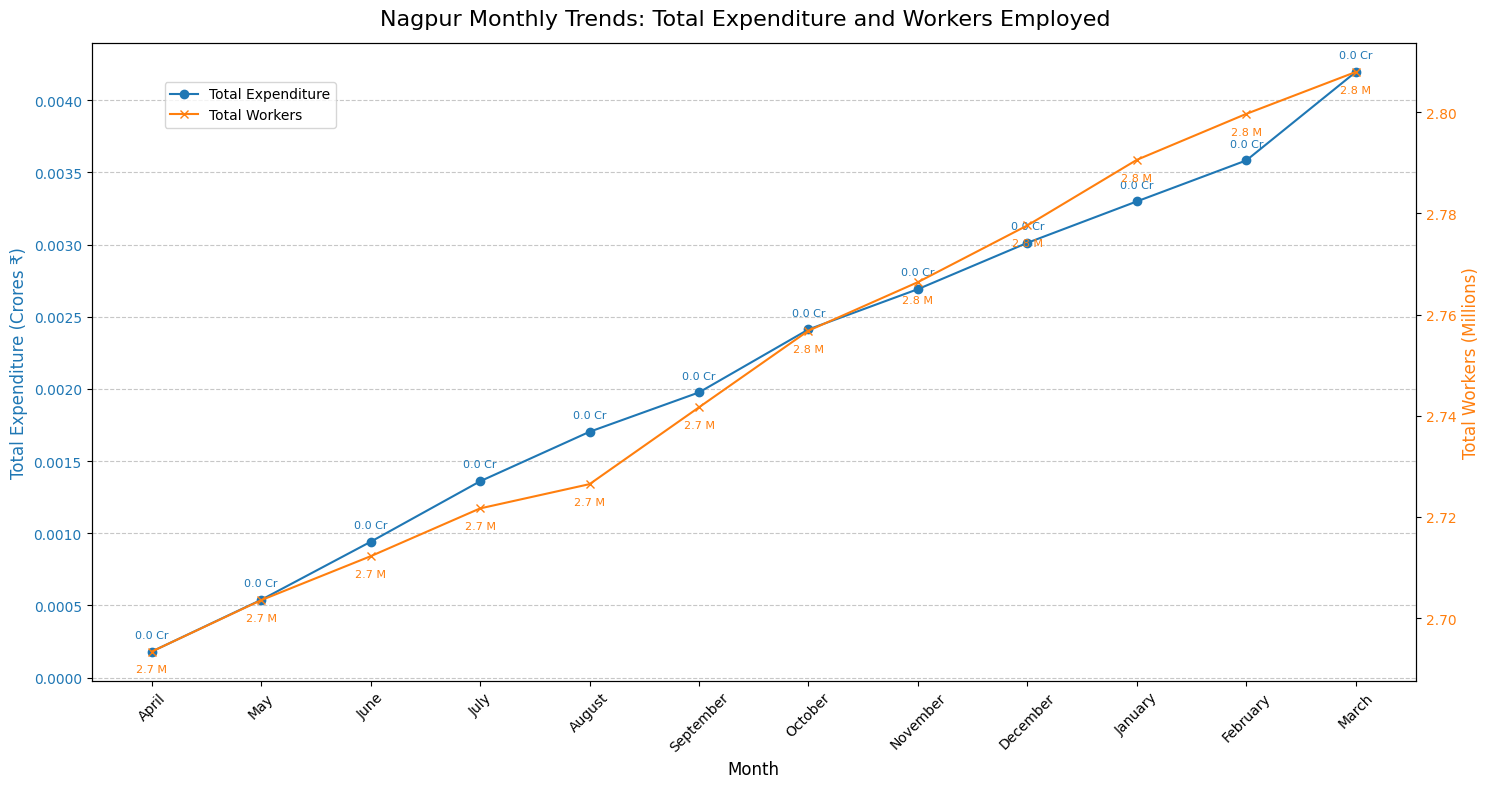

'\nPurpose: To identify seasonal patterns in MGNREGA expenditure and worker engagement for Nagpur district, aligned with the Indian financial year.\nInsights: Reveals peak and lean periods of activity within the financial year specific to Nagpur.\nInterpretation: Activity often aligns with agricultural cycles or local demand. Understanding these cycles is crucial for efficient resource planning. Annotated values provide precise figures.\n'

In [9]:
fig, ax1 = plt.subplots(figsize=(15, 8))

color = 'tab:blue'
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Total Expenditure (Crores ₹)', color=color, fontsize=12)
line1_monthly = ax1.plot(nagpur_monthly_trends.index, nagpur_monthly_trends['Total_Expenditure'] / 1e7, color=color, marker='o', label='Total Expenditure')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7) 

for x, y in zip(nagpur_monthly_trends.index, nagpur_monthly_trends['Total_Expenditure'] / 1e7):
    ax1.annotate(f'{y:.1f} Cr', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color=color)


ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Total Workers (Millions)', color=color, fontsize=12)
line2_monthly = ax2.plot(nagpur_monthly_trends.index, nagpur_monthly_trends['Total_Workers'] / 1e6, color=color, marker='x', label='Total Workers')
ax2.tick_params(axis='y', labelcolor=color)

for x, y in zip(nagpur_monthly_trends.index, nagpur_monthly_trends['Total_Workers'] / 1e6):
    ax2.annotate(f'{y:.1f} M', (x, y), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color=color)


fig.suptitle('Nagpur Monthly Trends: Total Expenditure and Workers Employed', fontsize=16)
lines_combined_monthly = line1_monthly + line2_monthly
labels_combined_monthly = [l.get_label() for l in lines_combined_monthly]
ax2.legend(lines_combined_monthly, labels_combined_monthly, loc='upper left', bbox_to_anchor=(0.05, 0.95))
fig.tight_layout()
plt.show()
"""
Purpose: To identify seasonal patterns in MGNREGA expenditure and worker engagement for Nagpur district, aligned with the Indian financial year.
Insights: Reveals peak and lean periods of activity within the financial year specific to Nagpur.
Interpretation: Activity often aligns with agricultural cycles or local demand. Understanding these cycles is crucial for efficient resource planning. Annotated values provide precise figures.
"""

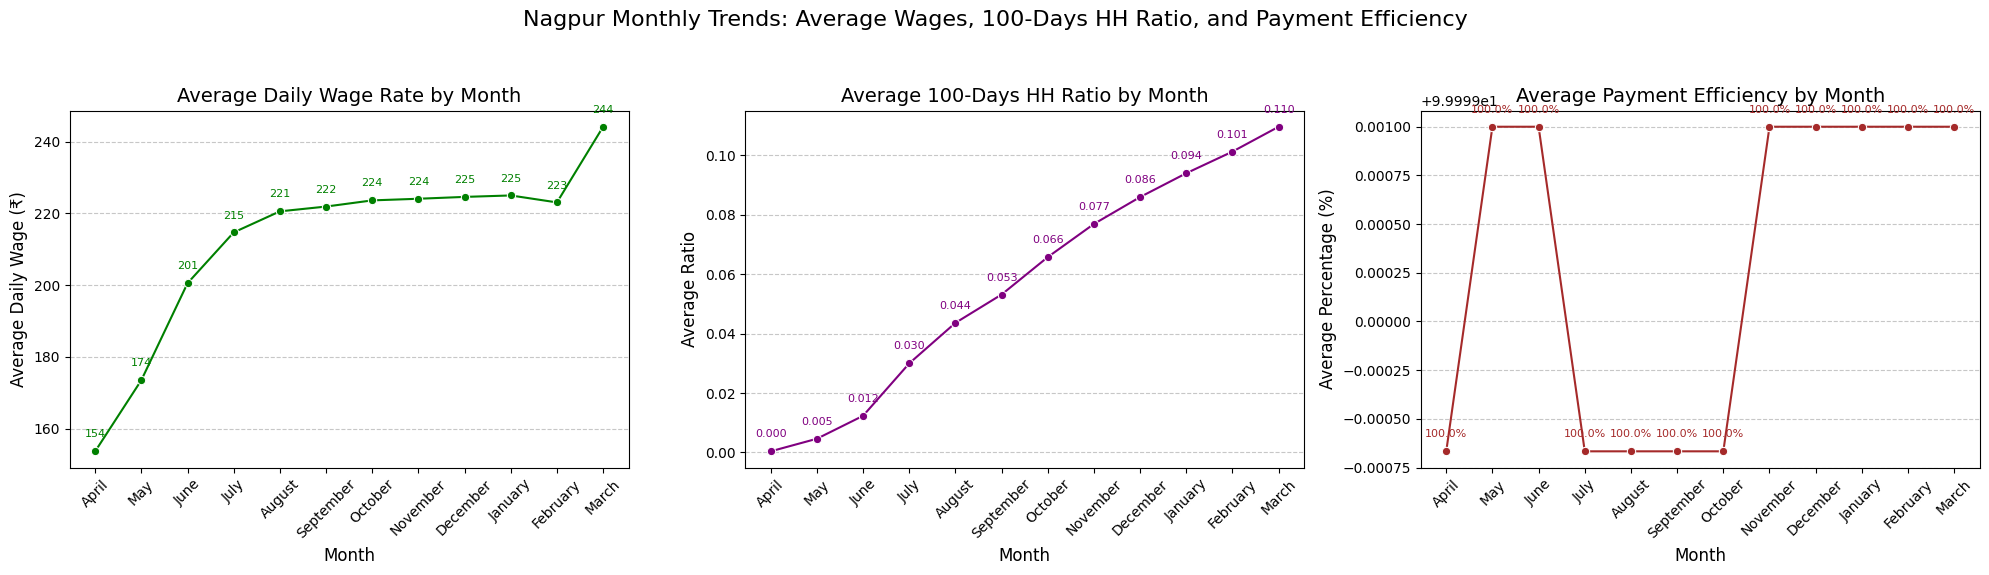

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Nagpur Monthly Trends: Average Wages, 100-Days HH Ratio, and Payment Efficiency', fontsize=16)

# Plot Avg_Daily_Wage by Month
sns.lineplot(x=nagpur_monthly_trends.index, y='Avg_Daily_Wage', data=nagpur_monthly_trends, marker='o', ax=axes[0], color='green')
axes[0].set_title('Average Daily Wage Rate by Month', fontsize=14)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Average Daily Wage (₹)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for x, y in zip(nagpur_monthly_trends.index, nagpur_monthly_trends['Avg_Daily_Wage']):
    axes[0].annotate(f'{y:.0f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='green')
"""
Purpose: To analyze monthly variations in average daily wage rates for Nagpur district.
Insights: Can show if wages fluctuate seasonally or are relatively stable locally.
Interpretation: Significant monthly fluctuations might indicate changes in local work types or economic conditions. Relative stability suggests consistent wage policy application. Annotated values provide precise figures.
"""

# Plot Avg_100_Days_HH_Ratio by Month
sns.lineplot(x=nagpur_monthly_trends.index, y='Avg_100_Days_HH_Ratio', data=nagpur_monthly_trends, marker='o', ax=axes[1], color='purple')
axes[1].set_title('Average 100-Days HH Ratio by Month', fontsize=14)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Average Ratio', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
for x, y in zip(nagpur_monthly_trends.index, nagpur_monthly_trends['Avg_100_Days_HH_Ratio']):
    axes[1].annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='purple')
"""
Purpose: To identify monthly patterns in the provision of 100 days of employment for Nagpur district.
Insights: Reveals if certain months are better or worse for achieving this key scheme objective locally.
Interpretation: Seasonal peaks might align with lean agricultural seasons when demand for work is highest. Understanding these patterns helps local planning. Annotated values provide precise figures.
"""

# Plot Avg_Payment_Efficiency by Month
sns.lineplot(x=nagpur_monthly_trends.index, y='Avg_Payment_Efficiency', data=nagpur_monthly_trends, marker='o', ax=axes[2], color='brown')
axes[2].set_title('Average Payment Efficiency by Month', fontsize=14)
axes[2].set_xlabel('Month', fontsize=12)
axes[2].set_ylabel('Average Percentage (%)', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
for x, y in zip(nagpur_monthly_trends.index, nagpur_monthly_trends['Avg_Payment_Efficiency']):
    axes[2].annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='brown')
"""
Purpose: To assess monthly consistency in payment efficiency for Nagpur district.
Insights: Can highlight months where administrative bottlenecks or external factors might cause payment delays locally.
Interpretation: Stable high efficiency indicates a robust local system. Dips can signal areas where the payment mechanism needs strengthening. Annotated values provide precise figures.
"""
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


--- Step 5: Monthly Trends by Financial Year for Nagpur District ---


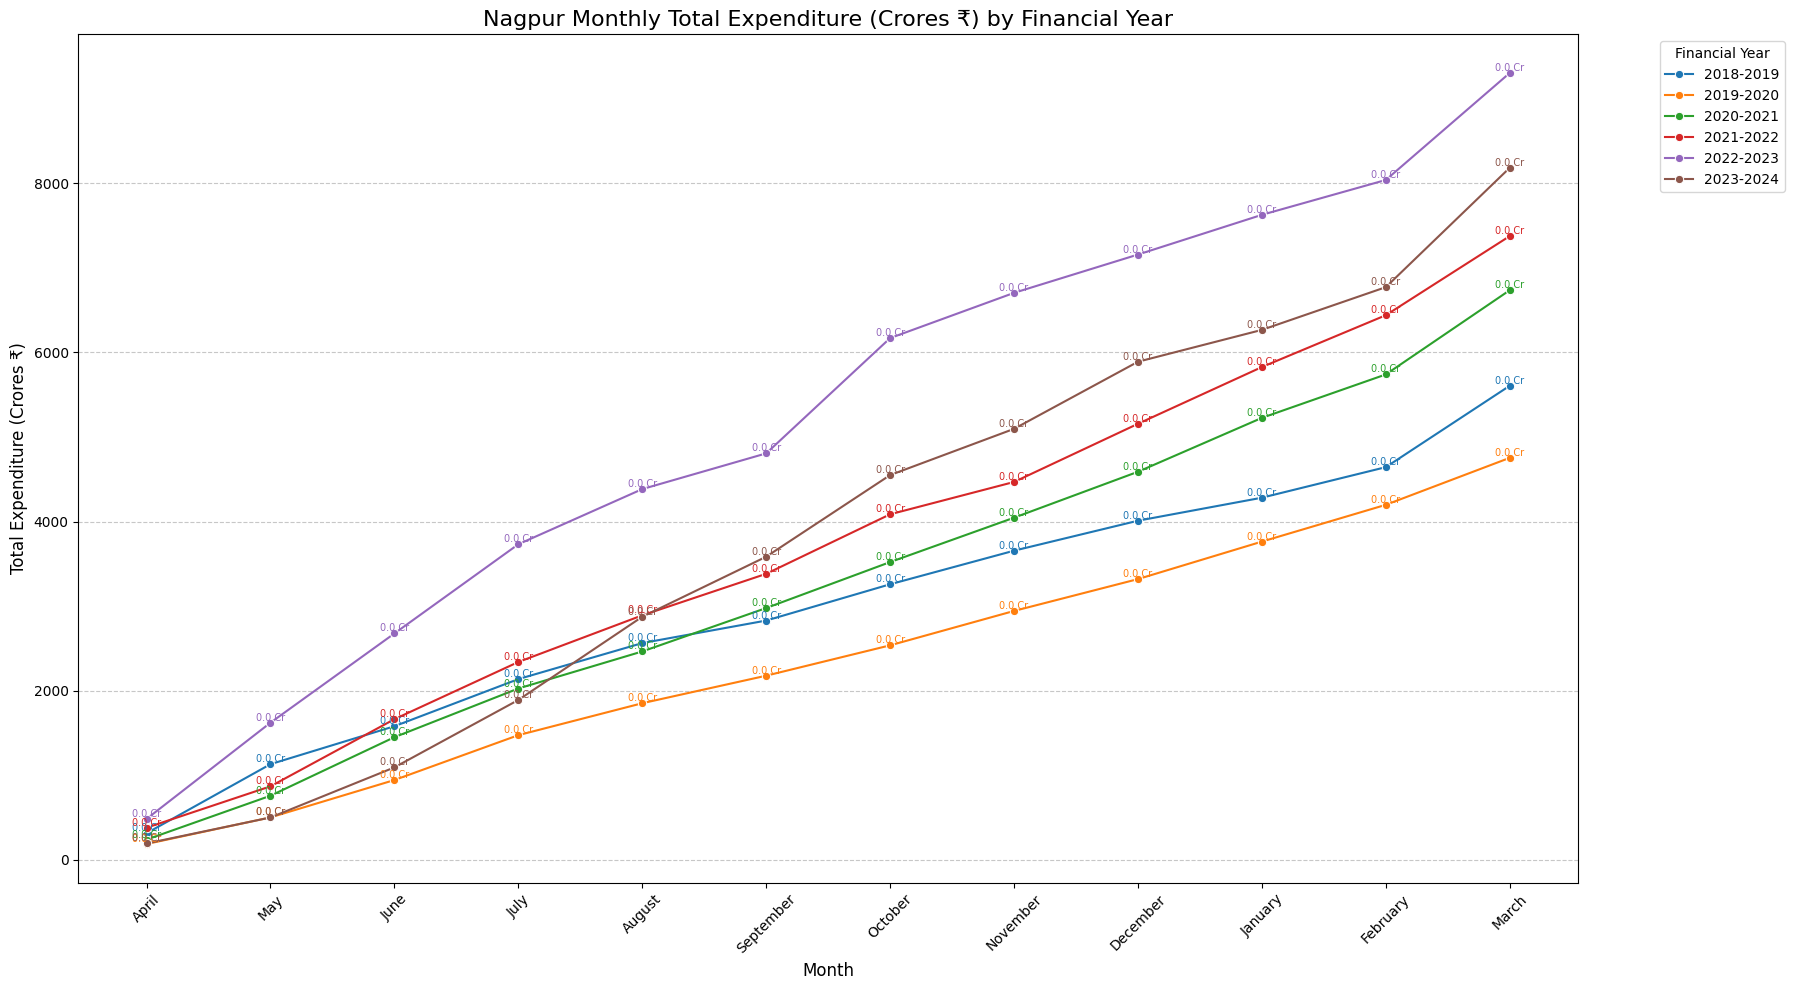

'\nPurpose: To visualize the month-wise trends of total expenditure for each financial year in Nagpur.\nInsights: Helps in identifying year-specific anomalies or deviations from typical seasonal patterns locally.\nInterpretation: Reveals if program scale increased in certain months in specific years for Nagpur. This granular view helps in understanding yearly operational nuances.\n'

In [11]:
# --- Step 5: Monthly Trends for Key Metrics by Financial Year (for Nagpur) ---
print("\n--- Step 5: Monthly Trends by Financial Year for Nagpur District ---")

# Aggregate monthly data by financial year and month for Nagpur
nagpur_monthly_yearly_trends = df_nagpur.groupby(['fin_year', 'month_full_name']).agg(
    Total_Expenditure=('Total_Exp', 'sum'),
    Total_Workers=('Total_No_of_Workers', 'sum'),
    Avg_Daily_Wage=('Average_Wage_rate_per_day_per_person', 'mean'),
    Avg_100_Days_HH_Ratio=('100_Days_HH_Ratio', 'mean'),
    Avg_Payment_Efficiency=('percentage_payments_gererated_within_15_days', 'mean')
).reset_index().rename(columns={'month_full_name': 'Month'})

# Fill NaNs only for numerical columns in this aggregated DataFrame
numerical_cols_for_fill = ['Total_Expenditure', 'Total_Workers', 'Avg_Daily_Wage', 'Avg_100_Days_HH_Ratio', 'Avg_Payment_Efficiency']
for col in numerical_cols_for_fill:
    if col in nagpur_monthly_yearly_trends.columns:
        nagpur_monthly_yearly_trends[col] = nagpur_monthly_yearly_trends[col].fillna(0)


# Plotting Total Expenditure by Month for Each Year in Nagpur
plt.figure(figsize=(18, 10))
lineplot_exp_yearly = sns.lineplot(data=nagpur_monthly_yearly_trends, x='Month', y='Total_Expenditure', hue='fin_year', marker='o', palette='tab10')
plt.title('Nagpur Monthly Total Expenditure (Crores ₹) by Financial Year', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Expenditure (Crores ₹)', fontsize=12)
plt.tick_params(axis='x', rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Financial Year', bbox_to_anchor=(1.05, 1), loc='upper left')

for line in lineplot_exp_yearly.get_lines():
    for x_val, y_val in zip(line.get_xdata(), line.get_ydata()):
        if pd.notna(y_val) and y_val != 0:
            plt.text(x_val, y_val, f'{y_val/1e7:.1f} Cr', fontsize=7, ha='center', va='bottom', color=line.get_color())
plt.tight_layout()
plt.show()
"""
Purpose: To visualize the month-wise trends of total expenditure for each financial year in Nagpur.
Insights: Helps in identifying year-specific anomalies or deviations from typical seasonal patterns locally.
Interpretation: Reveals if program scale increased in certain months in specific years for Nagpur. This granular view helps in understanding yearly operational nuances.
"""

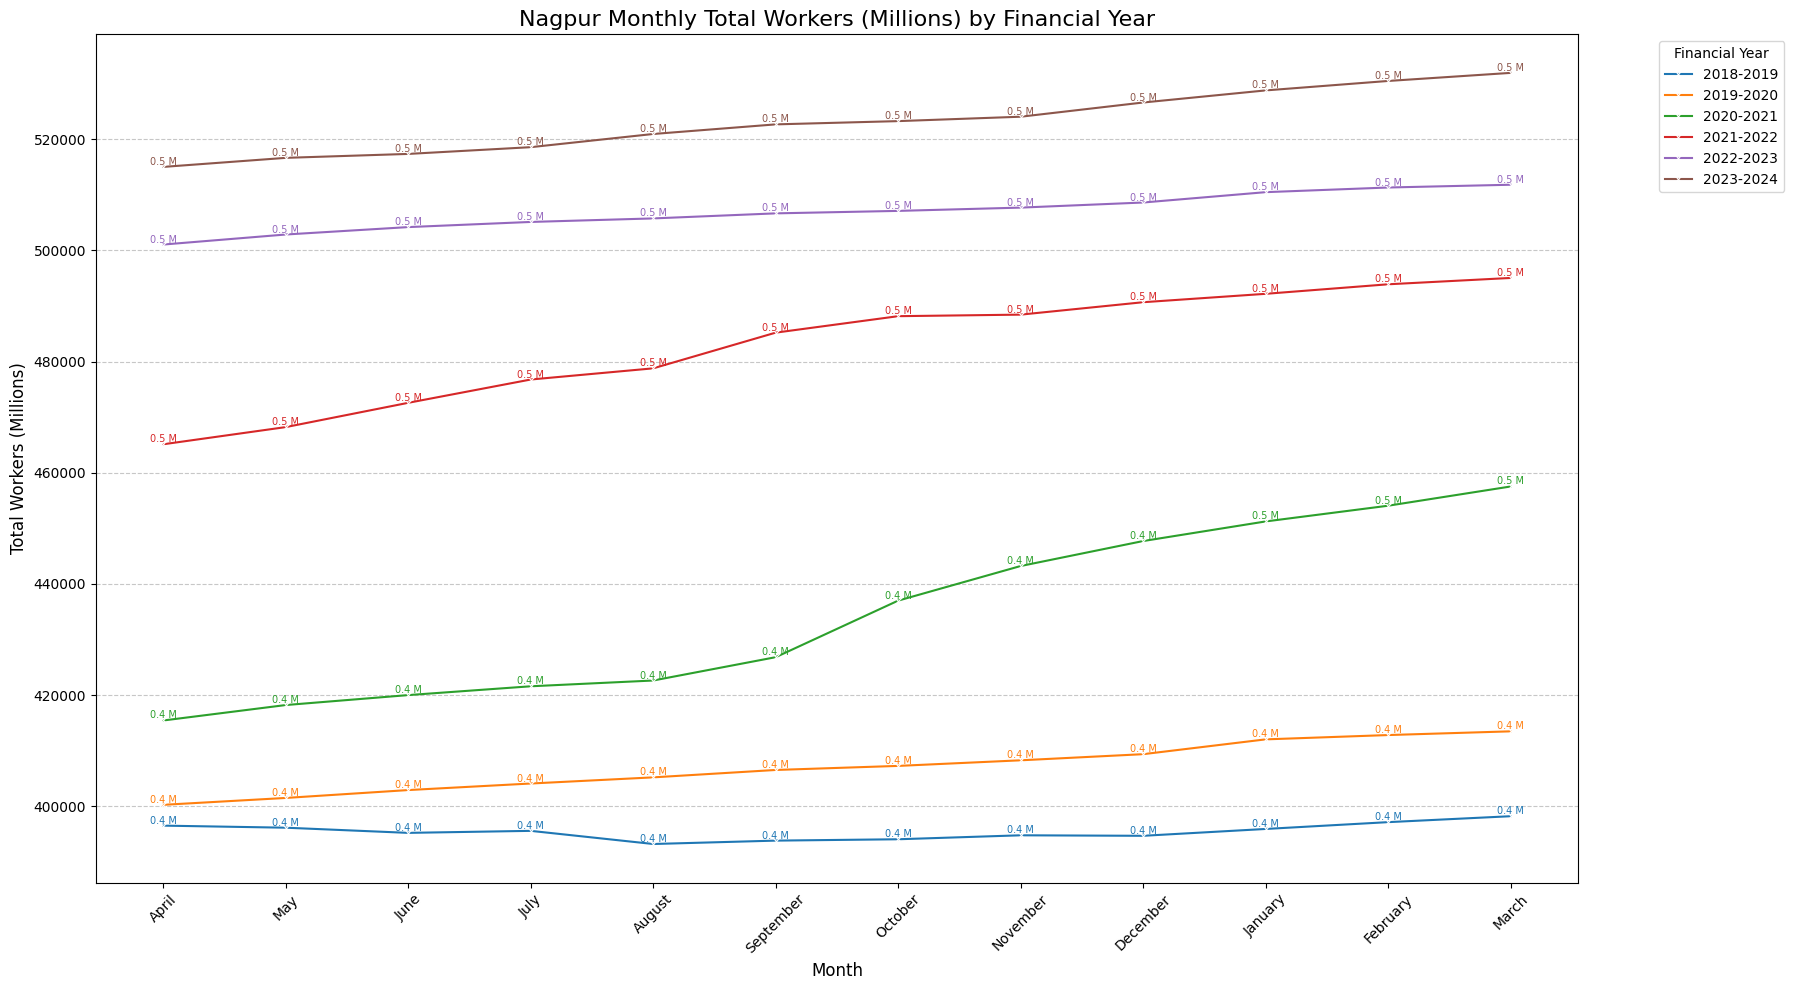


--- Nagpur District MGNREGA Analysis: Focused Trends and Patterns Completed. ---
This focused analysis provides detailed insights into MGNREGA implementation within Nagpur district.
The temporal trends and insights derived here can inform local policy decisions.


In [12]:
# Plotting Total Workers by Month for Each Year in Nagpur
plt.figure(figsize=(18, 10))
lineplot_workers_yearly = sns.lineplot(data=nagpur_monthly_yearly_trends, x='Month', y='Total_Workers', hue='fin_year', marker='x', palette='tab10')
plt.title('Nagpur Monthly Total Workers (Millions) by Financial Year', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Workers (Millions)', fontsize=12)
plt.tick_params(axis='x', rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Financial Year', bbox_to_anchor=(1.05, 1), loc='upper left')

for line in lineplot_workers_yearly.get_lines():
    for x_val, y_val in zip(line.get_xdata(), line.get_ydata()):
        if pd.notna(y_val) and y_val != 0:
            plt.text(x_val, y_val, f'{y_val/1e6:.1f} M', fontsize=7, ha='center', va='bottom', color=line.get_color())
plt.tight_layout()
plt.show()
"""
Purpose: To visualize the month-wise trends of total workers employed for each financial year in Nagpur.
Insights: Helps in identifying seasonal employment patterns and how they might vary year-on-year locally.
Interpretation: Shows how demand for work or availability of projects fluctuates monthly within each financial year. This is vital for understanding employment stability and planning resource allocation for Nagpur.
"""

# --- Step 6: Final Thoughts and Next Steps for Nagpur Analysis ---
print("\n--- Nagpur District MGNREGA Analysis: Focused Trends and Patterns Completed. ---")
print("This focused analysis provides detailed insights into MGNREGA implementation within Nagpur district.")
print("The temporal trends and insights derived here can inform local policy decisions.")

